In [81]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy.stats as stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from fig_code import visualize_tree, plot_tree_interactive
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.tree import plot_tree

from matplotlib import pyplot as plt
from pylab import rcParams
from IPython.display import Image
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
import numpy as np
sns.set(color_codes=True, font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

!pip install pmdarima
from pmdarima.arima import auto_arima

### Read the Covid Super Data

In [82]:
covid_merged_data = pd.read_csv('../../data/covid_large.csv')
covid_merged_data.head()

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population
0,AL,0,statewide unallocated,2020-01-22,0,0,0
1,AL,0,statewide unallocated,2020-01-23,0,0,0
2,AL,0,statewide unallocated,2020-01-24,0,0,0
3,AL,0,statewide unallocated,2020-01-25,0,0,0
4,AL,0,statewide unallocated,2020-01-26,0,0,0


### Task1: Member Task1

In [83]:
#Filter all rows which are in the state of "North Carolina"
NC_data= covid_merged_data[covid_merged_data['State']=="NC"]

#Calculate new cases and deaths for each day
NC_data['Num_of_Cases_per_day'] = NC_data['Num of Cases'].diff()
NC_data['Num_of_Deaths_per_day'] = NC_data['Num of Deaths'].diff()

#Drop the first date as we we are using .diff, we will get the first value as NAN 
NC_data = NC_data[NC_data['Date'] != '2020-01-22']
NC_data['Date'] = NC_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

# Get the total number of cases and deaths for edf_Mexico_cases_newach day 
NC_data_groupedBydate = NC_data.groupby("Date").sum().reset_index()

NC_data_groupedBydate

,Date,countyFIPS,Num of Cases,Num of Deaths,population,Num_of_Cases_per_day,Num_of_Deaths_per_day
0,2020-01-23,3710000,0,0,10488084,0.0,0.0
1,2020-01-24,3710000,0,0,10488084,0.0,0.0
2,2020-01-25,3710000,0,0,10488084,0.0,0.0
3,2020-01-26,3710000,0,0,10488084,0.0,0.0
4,2020-01-27,3710000,0,0,10488084,0.0,0.0
...,...,...,...,...,...,...,...
231,2020-09-10,3710000,181917,2990,10488084,1225.0,33.0
232,2020-09-11,3710000,183449,3023,10488084,1532.0,33.0
233,2020-09-12,3710000,184902,3047,10488084,1453.0,24.0
234,2020-09-13,3710000,186095,3052,10488084,1193.0,5.0


In [84]:
#Drop columns that are not necessary
NC_data_cleaned = NC_data_groupedBydate.drop(['countyFIPS','Num of Cases','Num of Deaths','population'],axis=1)
NC_data_cleaned

,Date,Num_of_Cases_per_day,Num_of_Deaths_per_day
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
231,2020-09-10,1225.0,33.0
232,2020-09-11,1532.0,33.0
233,2020-09-12,1453.0,24.0
234,2020-09-13,1193.0,5.0


In [85]:
NC_first_case_index = NC_data_cleaned['Num_of_Cases_per_day'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
NC_first_death_index= NC_data_cleaned['Num_of_Deaths_per_day'].ne(0).idxmax() 


In [86]:
# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=NC_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
NC_data_cleaned.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=NC_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
NC_data_cleaned.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

In [87]:
df_cases_brfore_drop = NC_data_cleaned[['numOfDaysSinceFirstCase','Num_of_Cases_per_day']]
df_cases_brfore_drop

,numOfDaysSinceFirstCase,Num_of_Cases_per_day
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
231,191,1225.0
232,192,1532.0
233,193,1453.0
234,194,1193.0


### Linear Regression Model of NC for cases

In [88]:
df_cases_brfore_drop = NC_data_cleaned[['numOfDaysSinceFirstCase','Num_of_Cases_per_day']]
#Drop all the rows 
df_cases = df_cases_brfore_drop[df_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]
df_cases

,numOfDaysSinceFirstCase,Num_of_Cases_per_day
41,1,0.0
42,2,0.0
43,3,1.0
44,4,0.0
45,5,0.0
...,...,...
231,191,1225.0
232,192,1532.0
233,193,1453.0
234,194,1193.0


#### Model Training 

In [89]:
#Define the independent and dependent variable
X = df_cases.iloc[:,0].values.reshape(-1, 1) 
y = df_cases.iloc[:,1].values.reshape(-1, 1) 

#Define and fit the LinearRegression model  
lr_model = LinearRegression()
lr_model.fit(X, y)

#predict the number of new cases per day since the fist case
cases_prediction = lr_model.predict(X)

#### Model Metrics and Prediction

In [90]:
#Function for getting confidence interval
def get_confidence_interval(prediction, y_test, test_predictions, pi=.95):  
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(sum_errs / (len(y_test) - 2))
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

Coefficient:  [[10.14917218]]
Y-intercept:  [-35.97784827]
MAE:  326.9272015971642
MSE:  210302.77627367363
RMSE:  458.58780650348046
r^2 Score:  0.608151059132406


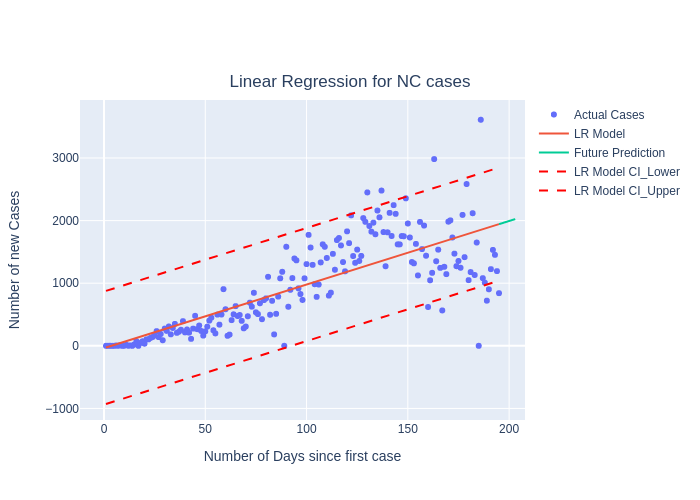

In [91]:
# Computing the Coefficient (the slope of the line)
print("Coefficient: ",lr_model.coef_)

# Computing the Y-intercept
print("Y-intercept: ",lr_model.intercept_)

#Caluculate the metrics
print("MAE: ",metrics.mean_absolute_error(y,cases_prediction))
print("MSE: ",metrics.mean_squared_error(y,cases_prediction))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y,cases_prediction)))

# Compute the r^2 Score
print("r^2 Score: ",r2_score(y,cases_prediction))

# Predict the number of new cases for the next 1 week's of data
future_dates = np.arange(195,204).reshape(-1,1)
future_cases = lr_model.predict(future_dates)

#Confidence Interval
[err_down, prediction, err_up] = get_confidence_interval(cases_prediction, y, cases_prediction, pi=.95)

#Plot the trend line and prediction path
fig = go.Figure([
    go.Scatter(x=X.squeeze(),y=y.squeeze(),name='Actual Cases',mode='markers'),
    go.Scatter(x=X.squeeze(),y=lr_model.predict(X).squeeze(),name='LR Model',mode='lines'),
    go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Prediction',mode='lines'),
    go.Scatter(x=X.squeeze(),y=err_down.squeeze(), name='LR Model CI_Lower',mode='lines', line={'dash': 'dash', 'color': 'red'}),
    go.Scatter(x=X.squeeze(),y=err_up.squeeze(), name='LR Model CI_Upper',mode='lines', line={'dash': 'dash', 'color': 'red'}),
])

fig.update_layout(
    title={'text':"Linear Regression for NC cases",
           'y':0.85,'x':0.5,
           'xanchor':'center', 
           'yanchor':'top'},
    xaxis_title="Number of Days since first case",
    yaxis_title="Number of new Cases",
)
fig.write_image("../../images/nc_lrCases.png")
Image(filename="../../images/nc_lrCases.png")
#fig.show()

### Linear Regression Model of NC for deaths

In [92]:
df_deaths_before_drop = NC_data_cleaned[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day']]
df_deaths = df_deaths_before_drop[df_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]
df_deaths

,numOfDaysSinceFirstDeath,Num_of_Deaths_per_day
63,1,0.0
64,2,2.0
65,3,1.0
66,4,0.0
67,5,2.0
...,...,...
231,169,33.0
232,170,33.0
233,171,24.0
234,172,5.0


#### Model Training 

In [93]:
#Define the independent and dependent variable
X = df_deaths.iloc[:,0].values.reshape(-1, 1) 
y = df_deaths.iloc[:,1].values.reshape(-1, 1) 

#Define and fit the LinearRegression model  
lr_model = LinearRegression()
lr_model.fit(X, y)

#predict the number of new deaths per day since the fist death
deaths_prediction = lr_model.predict(X)

#### Model Metrics and Prediction

Coefficient:  [[0.10514252]]
Y-intercept:  [8.53468208]
MAE:  10.439232620650483
MSE:  196.99262565082194
RMSE:  14.035406144847464
r^2 Score:  0.12277605732517471


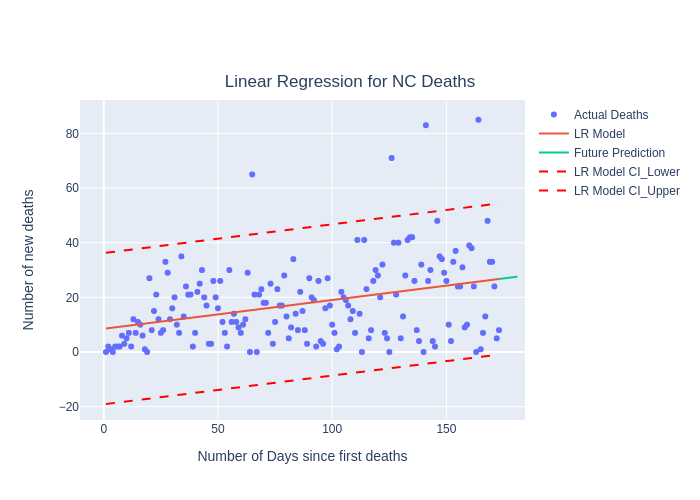

In [94]:
# Computing the Coefficient (the slope of the line)
print("Coefficient: ",lr_model.coef_)

# Computing the Y-intercept
print("Y-intercept: ",lr_model.intercept_)

#Caluculate the metrics
print("MAE: ",metrics.mean_absolute_error(y,deaths_prediction))
print("MSE: ",metrics.mean_squared_error(y,deaths_prediction))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))

# Compute the r^2 Score
print("r^2 Score: ",r2_score(y,deaths_prediction))

# Predict the number of new deaths for the next 1 week's of data
future_dates = np.arange(173,182).reshape(-1,1)
future_deaths = lr_model.predict(future_dates)

#Confidence Interval
[err_down, prediction, err_up] = get_confidence_interval(deaths_prediction, y, deaths_prediction, pi=.95)

#Plot the trend line and prediction path
fig = go.Figure([
    go.Scatter(x=X.squeeze(),y=y.squeeze(),name='Actual Deaths',mode='markers'),
    go.Scatter(x=X.squeeze(),y=lr_model.predict(X).squeeze(),name='LR Model',mode='lines'),
    go.Scatter(x=future_dates.squeeze(),y=future_deaths.squeeze(),name='Future Prediction',mode='lines'),
    go.Scatter(x=X.squeeze(),y=err_down.squeeze(), name='LR Model CI_Lower',mode='lines', line={'dash': 'dash', 'color': 'red'}),
    go.Scatter(x=X.squeeze(),y=err_up.squeeze(), name='LR Model CI_Upper',mode='lines', line={'dash': 'dash', 'color': 'red'}),
])

fig.update_layout(
    title={'text':"Linear Regression for NC Deaths",
           'y':0.85,'x':0.5,
           'xanchor':'center', 
           'yanchor':'top'},
    xaxis_title="Number of Days since first deaths",
    yaxis_title="Number of new deaths",
)
fig.write_image("../../images/nc_lrDeaths.png")
Image(filename="../../images/nc_lrDeaths.png")
#fig.show()

### Non-Linear Regression Model of NC for cases

MAE for degree =  1 is  326.9272015971642
MSE for degree =  1 is  210302.77627367357
RMSE for degree =  1 is  458.5878065034804
R^2 for degree =  1 is  0.608151059132406
-------------------------------------------------------
MAE for degree =  2 is  320.0565053700828
MSE for degree =  2 is  183443.27618923425
RMSE for degree =  2 is  428.3027856426272
R^2 for degree =  2 is  0.6581973155195506
-------------------------------------------------------
MAE for degree =  3 is  254.58665334973722
MSE for degree =  3 is  142215.13507379094
RMSE for degree =  3 is  377.1142201956735
R^2 for degree =  3 is  0.7350160989720473
-------------------------------------------------------
MAE for degree =  4 is  251.06093462795778
MSE for degree =  4 is  141881.32266832617
RMSE for degree =  4 is  376.6713722441967
R^2 for degree =  4 is  0.7356380785761568
-------------------------------------------------------


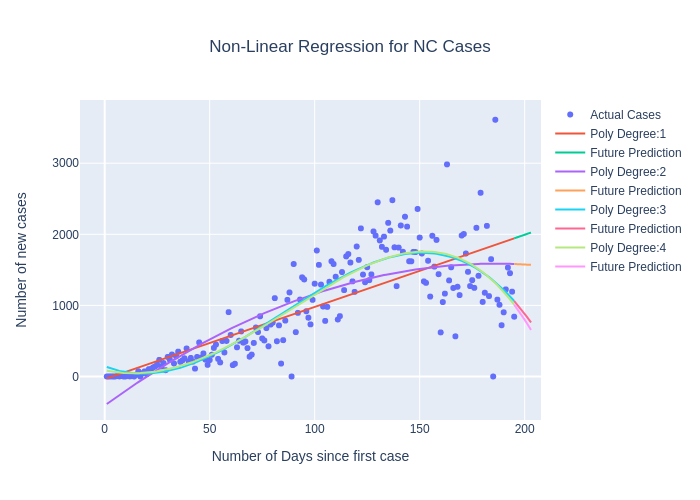

In [95]:
#Define the independent and dependent variable
X = df_cases.numOfDaysSinceFirstCase.values.reshape(-1, 1)
y_d = df_cases.Num_of_Cases_per_day.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), y_d.shape[0]).reshape(-1, 1)
future_dates = np.arange(195,204).reshape(-1,1)
fig = go.Figure()
fig.add_traces(go.Scatter(x=df_cases['numOfDaysSinceFirstCase'], y=df_cases['Num_of_Cases_per_day']
                          , name= "Actual Cases", mode="markers"))
fig1 = go.Figure()
fig1.add_traces(go.Scatter(x=df_cases['numOfDaysSinceFirstCase'], y=df_cases['Num_of_Cases_per_day']
                          , name= "Actual Cases", mode="markers"))
for degree in [1, 2, 3, 4]:
    
    #Define and fit the LinearRegression model
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)
    future_dates_poly = poly.transform(future_dates)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df_cases.Num_of_Cases_per_day)
    
    #predict the number of new cases per day since the fist case
    y_poly = model.predict(x_range_poly)
    
    # Predict the number of new cases for the next 1 week's of data
    future_cases = model.predict(future_dates_poly)
    
    #Caluculate the metrics and print
    print("MAE for degree = ",degree,"is ",metrics.mean_absolute_error(y_d,y_poly))
    print("MSE for degree = ",degree,"is ",metrics.mean_squared_error(y_d,y_poly))
    print("RMSE for degree = ",degree,"is ",np.sqrt(metrics.mean_squared_error(y_d,y_poly)))
    print("R^2 for degree = ",degree,"is ",r2_score(y_d,y_poly))
    print("-------------------------------------------------------")
    
    if degree == 3:
        [err_down, prediction, err_up] = get_confidence_interval(y_poly, y_d, y_poly, pi=.95)
        fig1.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
        fig1.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Degree:{} Prediction'.format(degree),mode='lines'))
        fig1.add_traces(go.Scatter(x=X.squeeze(),y=err_down.squeeze(), name='LR Model CI_Lower',mode='lines', line={'dash': 'dash', 'color': 'red'}))
        fig1.add_traces(go.Scatter(x=X.squeeze(),y=err_up.squeeze(), name='LR Model CI_Upper',mode='lines', line={'dash': 'dash', 'color': 'red'}))

        fig1.update_layout(
        title={'text':"Non-Linear Regression for NC Cases",
               'y':0.92,'x':0.5,
               'xanchor':'center', 
               'yanchor':'top'},
        xaxis_title="Number of Days since first case",
        yaxis_title="Number of new deaths")
        fig1.write_image("../../images/nc_nrCases1.png")
    
    #Plot the trend line and prediction path
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
    fig.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Prediction',mode='lines'))
    fig.update_layout(
    title={'text':"Non-Linear Regression for NC Cases",
           'y':0.92,'x':0.5,
           'xanchor':'center', 
           'yanchor':'top'},
    xaxis_title="Number of Days since first case",
    yaxis_title="Number of new cases",
)
fig.write_image("../../images/nc_nlrCases.png")
Image(filename="../../images/nc_nlrCases.png")

#fig.show()

### Conclusion
- From the above plot we observe that non-linear model with degree 3 model best fits the data 

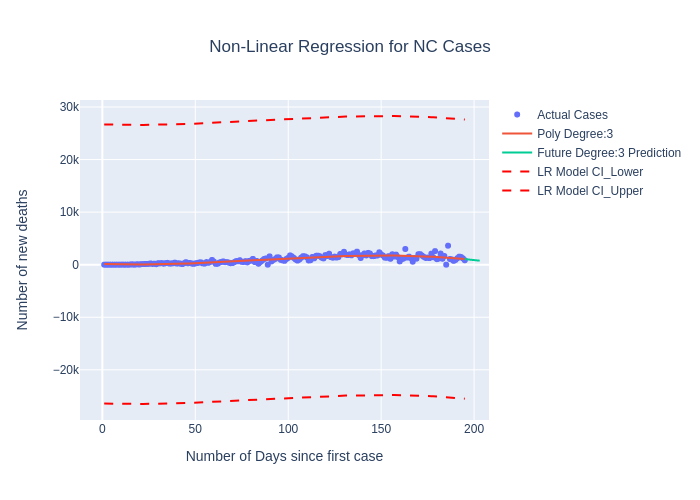

In [96]:
Image(filename="../../images/nc_nrCases1.png")

### Non-Linear Regression Model of NC for deaths

MAE for degree = 1 is  10.439232620650483
MSE for degree = 1 is  196.99262565082188
RMSE for degree = 1 is  14.035406144847462
R^2 for degree = 1 is  0.12277605732517494
-------------------------------------------------------
MAE for degree = 2 is  10.400965724350476
MSE for degree = 2 is  196.7296310299443
RMSE for degree = 2 is  14.026034044944575
R^2 for degree = 2 is  0.12394719343987104
-------------------------------------------------------
MAE for degree = 3 is  10.296397591320671
MSE for degree = 3 is  195.79620923410437
RMSE for degree = 3 is  13.992719865490924
R^2 for degree = 3 is  0.1281037954711406
-------------------------------------------------------
MAE for degree = 4 is  9.840205203115298
MSE for degree = 4 is  185.77258459580824
RMSE for degree = 4 is  13.629841693717806
R^2 for degree = 4 is  0.1727397989562891
-------------------------------------------------------


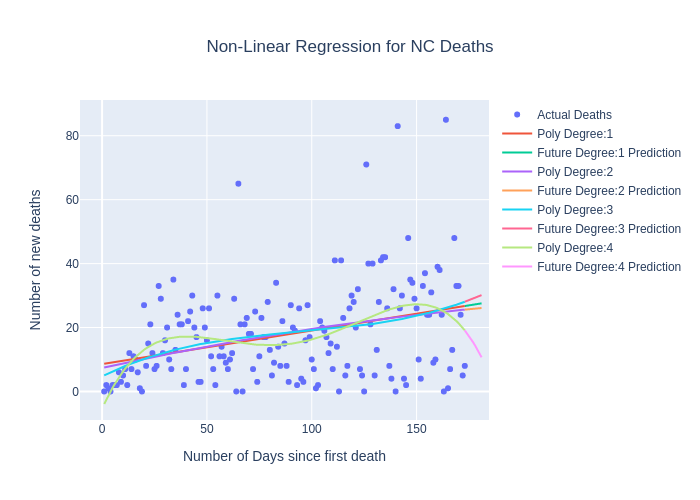

In [97]:
#Define the independent and dependent variable
X = df_deaths.numOfDaysSinceFirstDeath.values.reshape(-1, 1)
y_d = df_deaths.Num_of_Deaths_per_day.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), y_d.shape[0]).reshape(-1, 1)
future_dates = np.arange(173,182).reshape(-1,1)

fig = go.Figure()
fig.add_traces(go.Scatter(x=df_deaths['numOfDaysSinceFirstDeath'], y=df_deaths['Num_of_Deaths_per_day']
                          , name= "Actual Deaths", mode="markers"))
fig1 = go.Figure()
fig1.add_traces(go.Scatter(x=df_deaths['numOfDaysSinceFirstDeath'], y=df_deaths['Num_of_Deaths_per_day']
                          , name= "Actual Deaths", mode="markers"))
for degree in [1, 2, 3, 4]:
    
    #Define and fit the LinearRegression model
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)
    future_dates_poly = poly.transform(future_dates)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df_deaths.Num_of_Deaths_per_day)
    
    #predict the number of new deaths per day since the fist deaths
    y_poly = model.predict(x_range_poly)
    
    # Predict the number of new deaths for the next 1 week's of data
    future_cases = model.predict(future_dates_poly)
    
    if degree == 3:
        [err_down, prediction, err_up] = get_confidence_interval(y_poly, y_d, y_poly, pi=.95)
        fig1.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
        fig1.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Degree:{} Prediction'.format(degree),mode='lines'))
        fig1.add_traces(go.Scatter(x=X.squeeze(),y=err_down.squeeze(), name='LR Model CI_Lower',mode='lines', line={'dash': 'dash', 'color': 'red'}))
        fig1.add_traces(go.Scatter(x=X.squeeze(),y=err_up.squeeze(), name='LR Model CI_Upper',mode='lines', line={'dash': 'dash', 'color': 'red'}))
    
        fig1.update_layout(
        title={'text':"Non-Linear Regression for NC Deaths",
               'y':0.92,'x':0.5,
               'xanchor':'center', 
               'yanchor':'top'},
        xaxis_title="Number of Days since first death",
        yaxis_title="Number of new deaths")
        fig1.write_image("../../images/nc_nrDeaths1.png")
        
    #Caluculate the metrics and print
    print("MAE for degree =",degree,"is ",metrics.mean_absolute_error(y_d,y_poly))
    print("MSE for degree =",degree,"is ",metrics.mean_squared_error(y_d,y_poly))
    print("RMSE for degree =",degree,"is ",np.sqrt(metrics.mean_squared_error(y_d,y_poly)))
    print("R^2 for degree =",degree,"is ",r2_score(y_d,y_poly))
    print("-------------------------------------------------------")
    
    #Plot the trend line and prediction path
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
    fig.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Degree:{} Prediction'.format(degree),mode='lines')),
    
    
    fig.update_layout(
    title={'text':"Non-Linear Regression for NC Deaths",
           'y':0.92,'x':0.5,
           'xanchor':'center', 
           'yanchor':'top'},
    xaxis_title="Number of Days since first death",
    yaxis_title="Number of new deaths",
)
fig.write_image("../../images/nc_nrDeaths.png")
Image(filename="../../images/nc_nrDeaths.png")
#fig.show()

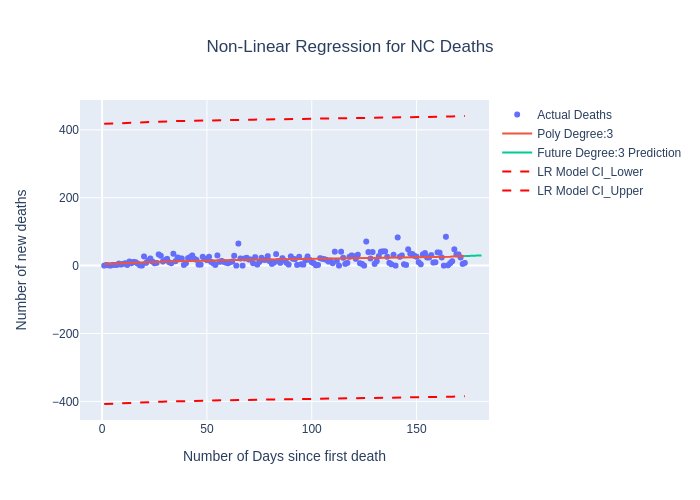

In [98]:
#Confidence Interval CI
Image(filename="../../images/nc_nrDeaths1.png")

### Conclusion
- From the above plot we observe that non-linear model with degree 3 model best fits the data 

### NC Counties Modeling

In [99]:
# Remove the rows that conatin county name as "statewide unallocated"
NC_county_data= NC_data[NC_data['County Name'] != 'statewide unallocated']

#normalize the total number of cases and deaths of each county by dividing it by total population and multiply by 1000
NC_county_data['Num_of_Cases_per_day_normalized'] = (NC_county_data['Num_of_Cases_per_day']/NC_county_data['population'])*100000
NC_county_data['Num_of_Deaths_per_day_normalized'] = (NC_county_data['Num_of_Deaths_per_day']/NC_county_data['population'])*100000
NC_county_data

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,Num_of_Cases_per_day,Num_of_Deaths_per_day,Num_of_Cases_per_day_normalized,Num_of_Deaths_per_day_normalized
456463,NC,37001,alamance county,2020-01-23,0,0,169509,0.0,0.0,0.000000,0.0
456464,NC,37001,alamance county,2020-01-24,0,0,169509,0.0,0.0,0.000000,0.0
456465,NC,37001,alamance county,2020-01-25,0,0,169509,0.0,0.0,0.000000,0.0
456466,NC,37001,alamance county,2020-01-26,0,0,169509,0.0,0.0,0.000000,0.0
456467,NC,37001,alamance county,2020-01-27,0,0,169509,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
480157,NC,37199,yancey county,2020-09-10,110,0,18069,2.0,0.0,11.068681,0.0
480158,NC,37199,yancey county,2020-09-11,112,0,18069,2.0,0.0,11.068681,0.0
480159,NC,37199,yancey county,2020-09-12,113,0,18069,1.0,0.0,5.534341,0.0
480160,NC,37199,yancey county,2020-09-13,114,0,18069,1.0,0.0,5.534341,0.0


#### Based on the project stage 2 normalized number of cases per day top 5 infected counties are 
- montgomery county
- duplin county	
- robeson county
- tyrrell county
- stanly county	

In [100]:
top5_county_data = NC_county_data[NC_county_data["County Name"].isin(["montgomery county","duplin county","robeson county","tyrrell county","stanly county"])]
top5_county_data

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,Num_of_Cases_per_day,Num_of_Deaths_per_day,Num_of_Cases_per_day_normalized,Num_of_Deaths_per_day_normalized
463573,NC,37061,duplin county,2020-01-23,0,0,58741,0.0,0.0,0.000000,0.0
463574,NC,37061,duplin county,2020-01-24,0,0,58741,0.0,0.0,0.000000,0.0
463575,NC,37061,duplin county,2020-01-25,0,0,58741,0.0,0.0,0.000000,0.0
463576,NC,37061,duplin county,2020-01-26,0,0,58741,0.0,0.0,0.000000,0.0
463577,NC,37061,duplin county,2020-01-27,0,0,58741,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
477550,NC,37177,tyrrell county,2020-09-10,108,2,4016,0.0,0.0,0.000000,0.0
477551,NC,37177,tyrrell county,2020-09-11,108,2,4016,0.0,0.0,0.000000,0.0
477552,NC,37177,tyrrell county,2020-09-12,110,2,4016,2.0,0.0,49.800797,0.0
477553,NC,37177,tyrrell county,2020-09-13,110,2,4016,0.0,0.0,0.000000,0.0


In [101]:
#Function to calculate the Linear and Non-linear model for new cases
def casesNonLinearModel(df_cases,future_dates,county_name):
    #Define the independent and dependent variable
    X = df_cases.numOfDaysSinceFirstCase.values.reshape(-1, 1)
    y_d = df_cases.Num_of_Cases_per_day_normalized.values.reshape(-1, 1)
    x_range = np.linspace(X.min(), X.max(), y_d.shape[0]).reshape(-1, 1)
    
    fig = go.Figure()
    fig.add_traces(go.Scatter(x=df_cases['numOfDaysSinceFirstCase'], y=df_cases['Num_of_Cases_per_day_normalized']
                              , name= "Actual Cases", mode="markers"))
    for degree in [1, 2, 3, 4]:

        #Define and fit the LinearRegression model
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)
        future_dates_poly = poly.transform(future_dates)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, df_cases.Num_of_Cases_per_day_normalized)

        #predict the number of new cases per day since the fist case
        y_poly = model.predict(x_range_poly)

        # Predict the number of new cases for the next 1 week's of data
        future_cases = model.predict(future_dates_poly)

        #Caluculate the metrics and print
        print("MAE for degree = ",degree,"is ",metrics.mean_absolute_error(y_d,y_poly))
        print("MSE for degree = ",degree,"is ",metrics.mean_squared_error(y_d,y_poly))
        print("RMSE for degree = ",degree,"is ",np.sqrt(metrics.mean_squared_error(y_d,y_poly)))
        print("R^2 for degree = ",degree,"is ",r2_score(y_d,y_poly))
        print("-------------------------------------------------------")

        #Plot the trend line and prediction path
        fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
        fig.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Degree:{} Prediction'.format(degree),mode='lines'))
        fig.update_layout(
        title={'text':"Non-Linear Regression for NC {} Cases".format(county_name),
               'y':0.92,'x':0.5,
               'xanchor':'center', 
               'yanchor':'top'},
        xaxis_title="Number of Days since first case",
        yaxis_title="Number of new cases per 100000",
    )
    fig_name = "../../images/nc_nlr{}CountyCases.png".format(county_name)
    fig.write_image(fig_name)
    Image(filename=fig_name)
    #fig.show()
    return fig_name
    

In [102]:
 def deathsNonLinearModel(df_deaths,future_dates,county_name):
    #Define the independent and dependent variable
    X = df_deaths.numOfDaysSinceFirstDeath.values.reshape(-1, 1)
    y_d = df_deaths.Num_of_Deaths_per_day_normalized.values.reshape(-1, 1)
    x_range = np.linspace(X.min(), X.max(), y_d.shape[0]).reshape(-1, 1)


    fig = go.Figure()
    fig.add_traces(go.Scatter(x=df_deaths['numOfDaysSinceFirstDeath'], y=df_deaths['Num_of_Deaths_per_day_normalized']
                              , name= "Actual Deaths", mode="markers"))
    for degree in [1, 2, 3, 4]:

        #Define and fit the LinearRegression model
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)
        future_dates_poly = poly.transform(future_dates)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, df_deaths.Num_of_Deaths_per_day_normalized)

        #predict the number of new deaths per day since the fist deaths
        y_poly = model.predict(x_range_poly)

        # Predict the number of new deaths for the next 1 week's of data
        future_cases = model.predict(future_dates_poly)

        #Caluculate the metrics and print
        print("MAE for degree =",degree,"is ",metrics.mean_absolute_error(y_d,y_poly))
        print("MSE for degree =",degree,"is ",metrics.mean_squared_error(y_d,y_poly))
        print("RMSE for degree =",degree,"is ",np.sqrt(metrics.mean_squared_error(y_d,y_poly)))
        print("R^2 for degree =",degree,"is ",r2_score(y_d,y_poly))
        print("-------------------------------------------------------")

        #Plot the trend line and prediction path
        fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
        fig.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Future Degree:{} Prediction'.format(degree),mode='lines')),
        fig.update_layout(
        title={'text':"Non-Linear Regression for {} Deaths".format(county_name),
               'y':0.92,'x':0.5,
               'xanchor':'center', 
               'yanchor':'top'},
        xaxis_title="Number of Days since first death",
        yaxis_title="Number of new deaths per 100000",
    )
    fig_name = "../../images/nc_nlr{}CountyDeaths.png".format(county_name)
    fig.write_image(fig_name)
    Image(filename=fig_name)
    #fig.show()
    return fig_name

### Montgomery County Model

MAE for degree =  1 is  11.88105686264195
MSE for degree =  1 is  281.4889390548161
RMSE for degree =  1 is  16.77763210512187
R^2 for degree =  1 is  0.344721651746421
-------------------------------------------------------
MAE for degree =  2 is  11.835301573472867
MSE for degree =  2 is  275.972022500775
RMSE for degree =  2 is  16.6124056807187
R^2 for degree =  2 is  0.3575644866340856
-------------------------------------------------------
MAE for degree =  3 is  11.386349803905386
MSE for degree =  3 is  267.002010111959
RMSE for degree =  3 is  16.34019614667948
R^2 for degree =  3 is  0.3784457863458758
-------------------------------------------------------
MAE for degree =  4 is  11.387522907861843
MSE for degree =  4 is  266.68768532695066
RMSE for degree =  4 is  16.330575168283286
R^2 for degree =  4 is  0.37917750328874067
-------------------------------------------------------


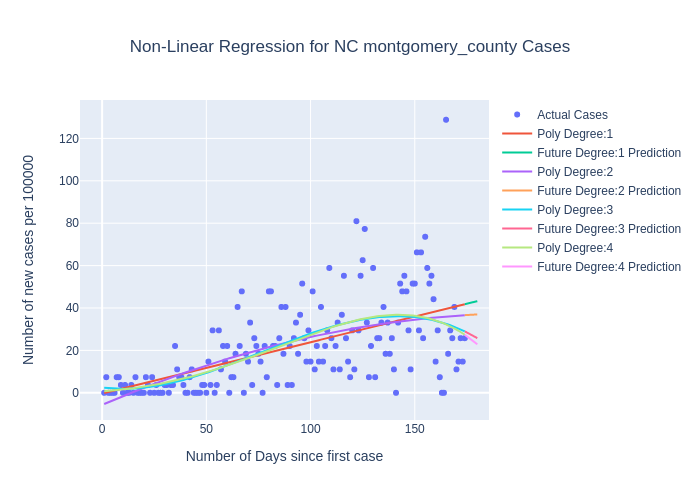

In [103]:
#Select the montgomery_data 
montgomery_data = top5_county_data[top5_county_data['County Name']=='montgomery county'].reset_index()

# Get the index of the row when the first case was detected 
montgomery_data_first_case_index = montgomery_data['Num_of_Cases_per_day_normalized'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
montgomery_data_first_death_index= montgomery_data['Num_of_Deaths_per_day_normalized'].ne(0).idxmax() 

# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=montgomery_data_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
montgomery_data.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=montgomery_data_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
montgomery_data.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

#Select the wo colums which are required
montgomery_cases_brfore_drop = montgomery_data[['numOfDaysSinceFirstCase','Num_of_Cases_per_day_normalized']]
#Drop all the rows before the first case
df_cases = montgomery_cases_brfore_drop[montgomery_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]

montgomery_deaths_before_drop = montgomery_data[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day_normalized']]
df_deaths = montgomery_deaths_before_drop[montgomery_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]

future_dates_cases = np.arange(174,181).reshape(-1,1)
future_dates_deaths = np.arange(165,172).reshape(-1,1)

fig_cases = casesNonLinearModel(df_cases,future_dates_cases,"montgomery_county")
Image(filename=fig_cases) 

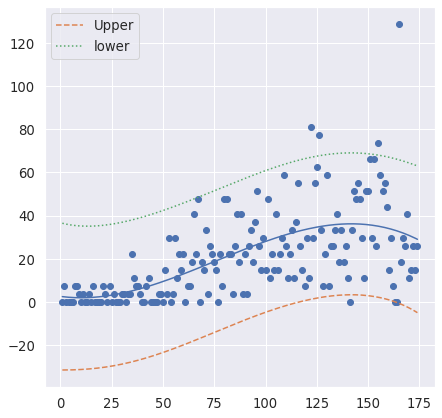

In [104]:
import statsmodels.api as sm
X = df_cases["numOfDaysSinceFirstCase"].values.reshape(-1,1)
y = df_cases["Num_of_Cases_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Conclusion
- From the above plot we observe that non-linear model with degree 3 model best fits the data 

MAE for degree = 1 is  0.83127098006423
MSE for degree = 1 is  2.1240976705321315
RMSE for degree = 1 is  1.4574284443951722
R^2 for degree = 1 is  0.043909880891955355
-------------------------------------------------------
MAE for degree = 2 is  0.8290396766503852
MSE for degree = 2 is  2.1203592560543605
RMSE for degree = 2 is  1.4561453416655772
R^2 for degree = 2 is  0.045592600661819804
-------------------------------------------------------
MAE for degree = 3 is  0.8399464533184714
MSE for degree = 3 is  2.1069937797560656
RMSE for degree = 3 is  1.4515487521113666
R^2 for degree = 3 is  0.051608613956901084
-------------------------------------------------------
MAE for degree = 4 is  0.8244544459316551
MSE for degree = 4 is  2.089816751063049
RMSE for degree = 4 is  1.4456198501207187
R^2 for degree = 4 is  0.059340267560623605
-------------------------------------------------------


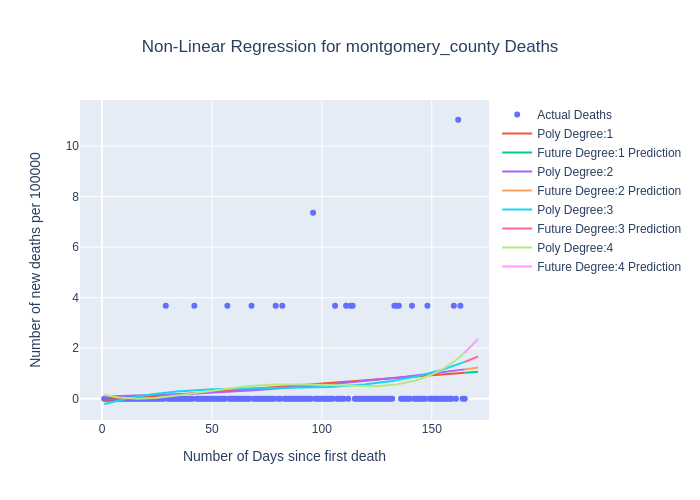

In [105]:
fig_deaths = deathsNonLinearModel(df_deaths,future_dates_deaths,"montgomery_county")
Image(filename=fig_deaths)

### Conclusion
- From the above plot we observe that non-linear model with degree 3 model best fits the data 

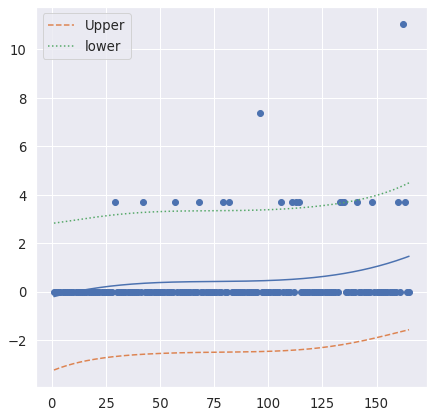

In [106]:
#Confidence Interval
import statsmodels.api as sm
X = df_deaths["numOfDaysSinceFirstDeath"].values.reshape(-1,1)
y = df_deaths["Num_of_Deaths_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Duplin County Model

MAE for degree =  1 is  17.110728501703623
MSE for degree =  1 is  449.60441609108244
RMSE for degree =  1 is  21.203877383419346
R^2 for degree =  1 is  0.01010305127672495
-------------------------------------------------------
MAE for degree =  2 is  12.089026094404323
MSE for degree =  2 is  271.32834522884406
RMSE for degree =  2 is  16.47204739031685
R^2 for degree =  2 is  0.40261462870116294
-------------------------------------------------------
MAE for degree =  3 is  11.534348682197534
MSE for degree =  3 is  242.05489199845613
RMSE for degree =  3 is  15.55811338172004
R^2 for degree =  3 is  0.46706617987428156
-------------------------------------------------------
MAE for degree =  4 is  10.755948943291164
MSE for degree =  4 is  228.8840685047575
RMSE for degree =  4 is  15.128914981080351
R^2 for degree =  4 is  0.4960644670840404
-------------------------------------------------------


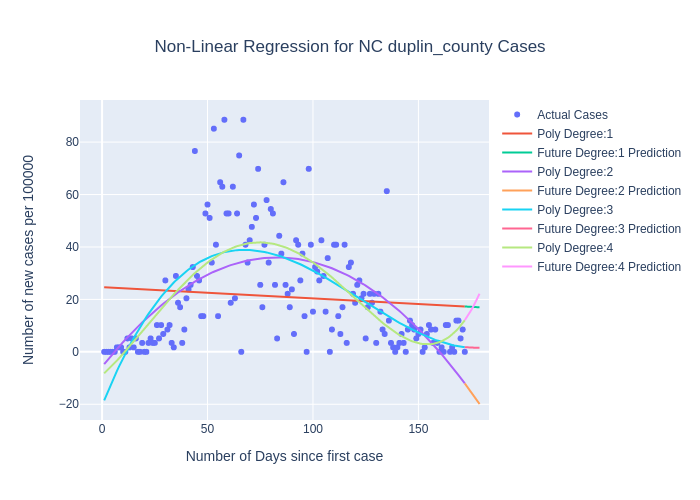

In [107]:
#Select the duplin_data 
duplin_data = top5_county_data[top5_county_data['County Name']=='duplin county'].reset_index()

# Get the index of the row when the first case was detected 
duplin_data_first_case_index = duplin_data['Num_of_Cases_per_day_normalized'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
duplin_data_first_death_index= duplin_data['Num_of_Deaths_per_day_normalized'].ne(0).idxmax() 

# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=duplin_data_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
duplin_data.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=duplin_data_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
duplin_data.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

#Select the wo colums which are required
duplin_cases_brfore_drop = duplin_data[['numOfDaysSinceFirstCase','Num_of_Cases_per_day_normalized']]
#Drop all the rows before the first case
df_cases = duplin_cases_brfore_drop[duplin_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]

duplin_deaths_before_drop = duplin_data[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day_normalized']]
df_deaths = duplin_deaths_before_drop[duplin_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]

future_dates_cases = np.arange(172,180).reshape(-1,1)
future_dates_deaths = np.arange(134,142).reshape(-1,1)

fig_cases = casesNonLinearModel(df_cases,future_dates_cases,"duplin_county")
Image(filename=fig_cases)  

### From the above plot we can observe that non-linear model with degree 3 model best fits the data 

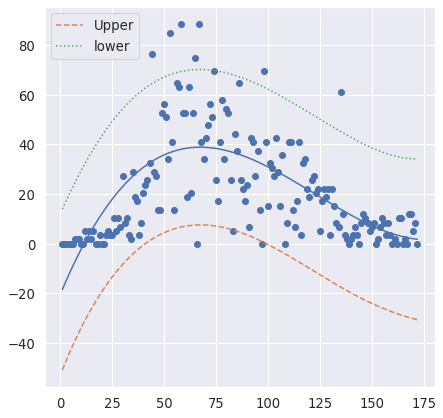

In [108]:
#Confidence Interval
X = df_cases["numOfDaysSinceFirstCase"].values.reshape(-1,1)
y = df_cases["Num_of_Cases_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

MAE for degree = 1 is  1.0589511586906208
MSE for degree = 1 is  3.377729357731758
RMSE for degree = 1 is  1.8378599940506235
R^2 for degree = 1 is  0.008974346649405107
-------------------------------------------------------
MAE for degree = 2 is  1.0573049671581112
MSE for degree = 2 is  3.357970698183929
RMSE for degree = 2 is  1.8324766569274298
R^2 for degree = 2 is  0.014771536540565844
-------------------------------------------------------
MAE for degree = 3 is  1.0544309001370002
MSE for degree = 3 is  3.3462298952265184
RMSE for degree = 3 is  1.8292703177022576
R^2 for degree = 3 is  0.018216287640915096
-------------------------------------------------------
MAE for degree = 4 is  1.0482571736074573
MSE for degree = 4 is  3.345318460341528
RMSE for degree = 4 is  1.8290211754765247
R^2 for degree = 4 is  0.01848370259833798
-------------------------------------------------------


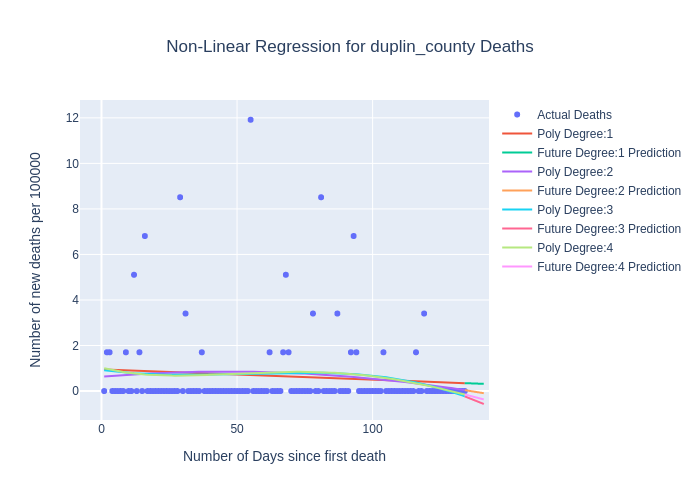

In [109]:
fig_deaths = deathsNonLinearModel(df_deaths,future_dates_deaths,"duplin_county")
Image(filename=fig_deaths)

### From the above the plot we can observe that non-linear model with degree 2 model best fits the data 

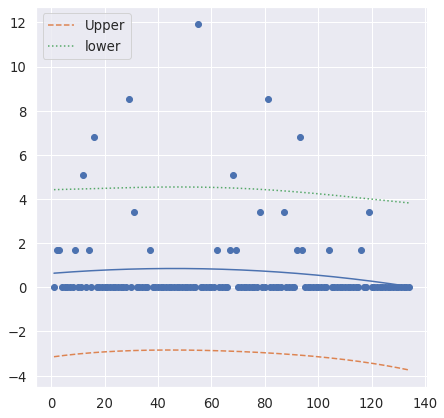

In [110]:
#Confidence Inteval
X = df_deaths["numOfDaysSinceFirstDeath"].values.reshape(-1,1)
y = df_deaths["Num_of_Deaths_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Tyrrell County Model

MAE for degree =  1 is  23.475300846511686
MSE for degree =  1 is  2062.3330660861566
RMSE for degree =  1 is  45.41291739236928
R^2 for degree =  1 is  0.024644481193760504
-------------------------------------------------------
MAE for degree =  2 is  23.777104634809504
MSE for degree =  2 is  1921.2825157824923
RMSE for degree =  2 is  43.83243679950377
R^2 for degree =  2 is  0.09135263562898055
-------------------------------------------------------
MAE for degree =  3 is  21.53154258748355
MSE for degree =  3 is  1803.2768175530264
RMSE for degree =  3 is  42.465006976957234
R^2 for degree =  3 is  0.1471620055660694
-------------------------------------------------------
MAE for degree =  4 is  22.468730402282993
MSE for degree =  4 is  1730.1238837943897
RMSE for degree =  4 is  41.594757888397304
R^2 for degree =  4 is  0.18175880219007934
-------------------------------------------------------


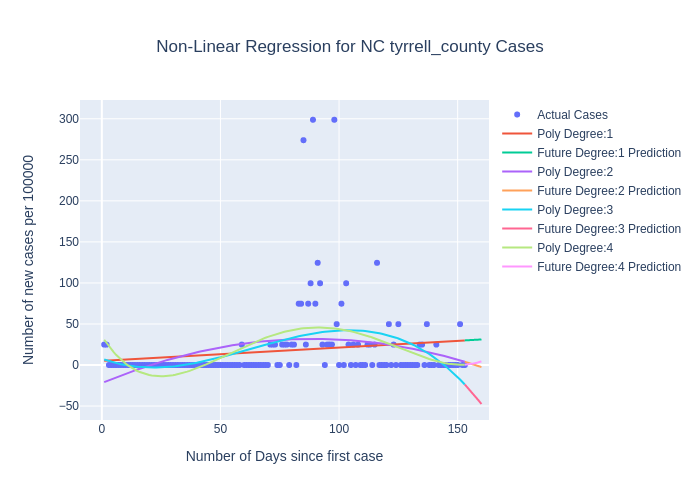

In [111]:
#Select the duplin_data 
tyrrell_county_data = top5_county_data[top5_county_data['County Name']=='tyrrell county'].reset_index()

# Get the index of the row when the first case was detected 
tyrrell_county_first_case_index = tyrrell_county_data['Num_of_Cases_per_day_normalized'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
tyrrell_county_first_death_index= tyrrell_county_data['Num_of_Deaths_per_day_normalized'].ne(0).idxmax() 

# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=tyrrell_county_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
tyrrell_county_data.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=tyrrell_county_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
tyrrell_county_data.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

#Select the wo colums which are required
tyrrell_county_cases_brfore_drop = tyrrell_county_data[['numOfDaysSinceFirstCase','Num_of_Cases_per_day_normalized']]
#Drop all the rows before the first case
df_cases = tyrrell_county_cases_brfore_drop[tyrrell_county_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]

tyrrell_county_deaths_before_drop = tyrrell_county_data[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day_normalized']]
df_deaths = tyrrell_county_deaths_before_drop[tyrrell_county_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]
df_deaths

future_dates_cases = np.arange(153,161).reshape(-1,1)
future_dates_deaths = np.arange(65,73).reshape(-1,1)
fig_cases = casesNonLinearModel(df_cases,future_dates_cases,"tyrrell_county")
Image(filename=fig_cases)

###  From the above the plot we can observe that non-linear model with degree 2 model best fits the data 

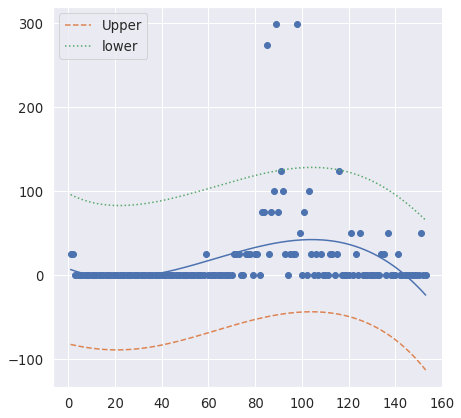

In [112]:
#Confidence Interval
X = df_cases["numOfDaysSinceFirstCase"].values.reshape(-1,1)
y = df_cases["Num_of_Cases_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

MAE for degree = 1 is  0.7543789339682689
MSE for degree = 1 is  9.392168002592994
RMSE for degree = 1 is  3.0646644192460935
R^2 for degree = 1 is  0.0
-------------------------------------------------------
MAE for degree = 2 is  0.8637223268937637
MSE for degree = 2 is  9.20859684404906
RMSE for degree = 2 is  3.034566994490163
R^2 for degree = 2 is  0.019545131485430467
-------------------------------------------------------
MAE for degree = 3 is  0.8637223268943731
MSE for degree = 3 is  9.208596844049062
RMSE for degree = 3 is  3.034566994490163
R^2 for degree = 3 is  0.019545131485430245
-------------------------------------------------------
MAE for degree = 4 is  0.9188867146259665
MSE for degree = 4 is  9.022421932080313
RMSE for degree = 4 is  3.0037346640607776
R^2 for degree = 4 is  0.03936748899834419
-------------------------------------------------------


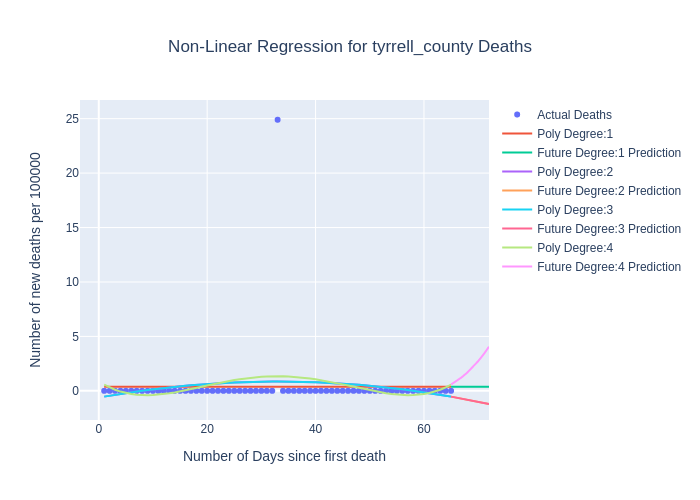

In [113]:
fig_deaths = deathsNonLinearModel(df_deaths,future_dates_deaths,"tyrrell_county")
Image(filename=fig_deaths)

### From the above the plot we can observe that non-linear model with degree 2 model best fits the data 

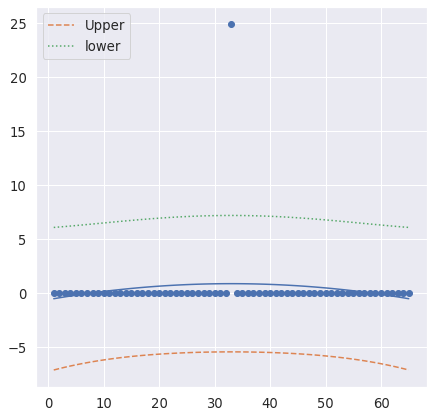

In [114]:
#Confidence Inteval
X = df_deaths["numOfDaysSinceFirstDeath"].values.reshape(-1,1)
y = df_deaths["Num_of_Deaths_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Robeson County Model

MAE for degree =  1 is  11.531062947847165
MSE for degree =  1 is  260.9097717787686
RMSE for degree =  1 is  16.152701686676707
R^2 for degree =  1 is  0.24645726011622227
-------------------------------------------------------
MAE for degree =  2 is  11.25378271830579
MSE for degree =  2 is  257.18487231149226
RMSE for degree =  2 is  16.03698451428735
R^2 for degree =  2 is  0.25721527401208744
-------------------------------------------------------
MAE for degree =  3 is  11.284547423455447
MSE for degree =  3 is  255.69584722986994
RMSE for degree =  3 is  15.99049240110729
R^2 for degree =  3 is  0.2615157800150315
-------------------------------------------------------
MAE for degree =  4 is  11.358093425753879
MSE for degree =  4 is  252.49609633426522
RMSE for degree =  4 is  15.890125749479305
R^2 for degree =  4 is  0.27075709374728996
-------------------------------------------------------


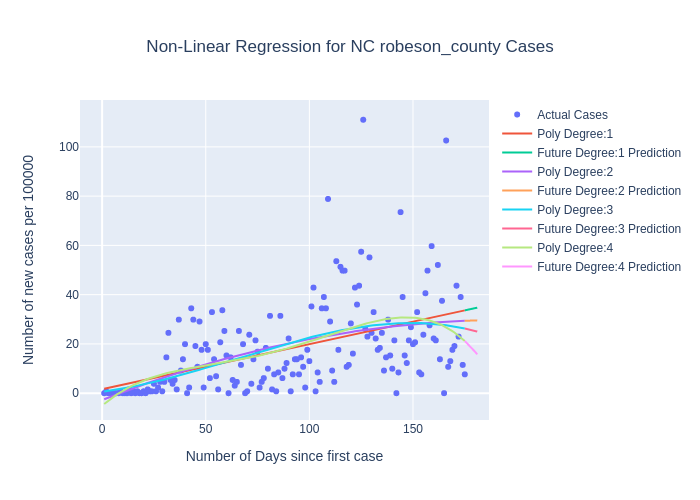

In [115]:
#Select the Robeson county 
robeson_county_data = top5_county_data[top5_county_data['County Name']=='robeson county'].reset_index()

# Get the index of the row when the first case was detected 
robeson_county_first_case_index = robeson_county_data['Num_of_Cases_per_day_normalized'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
robeson_county_first_death_index= robeson_county_data['Num_of_Deaths_per_day_normalized'].ne(0).idxmax() 

# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=robeson_county_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
robeson_county_data.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=robeson_county_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
robeson_county_data.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

#Select the wo colums which are required
robeson_county_cases_brfore_drop = robeson_county_data[['numOfDaysSinceFirstCase','Num_of_Cases_per_day_normalized']]
#Drop all the rows before the first case
df_cases = robeson_county_cases_brfore_drop[robeson_county_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]

robeson_county_deaths_before_drop = robeson_county_data[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day_normalized']]
df_deaths = robeson_county_deaths_before_drop[robeson_county_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]
df_deaths

future_dates_cases = np.arange(175,182).reshape(-1,1)
future_dates_deaths = np.arange(143,151).reshape(-1,1)
fig_cases = casesNonLinearModel(df_cases,future_dates_cases,"robeson_county")
Image(filename=fig_cases)

### From the above plot we observe that non-linear model with degree 3 best fits the data 

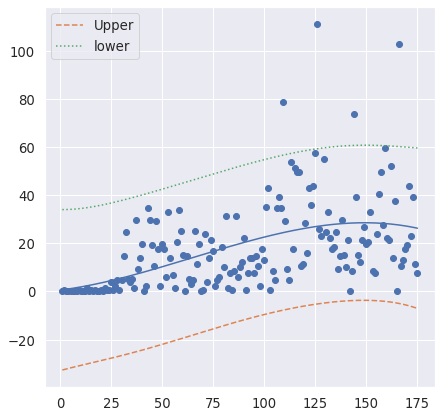

In [116]:
#Confidence Interval
X = df_cases["numOfDaysSinceFirstCase"].values.reshape(-1,1)
y = df_cases["Num_of_Cases_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

MAE for degree = 1 is  0.53687014855774
MSE for degree = 1 is  0.7016760628742222
RMSE for degree = 1 is  0.8376610668248956
R^2 for degree = 1 is  0.0002117545740522031
-------------------------------------------------------
MAE for degree = 2 is  0.5231153179747735
MSE for degree = 2 is  0.6853496040702899
RMSE for degree = 2 is  0.8278584444639614
R^2 for degree = 2 is  0.02347462823506874
-------------------------------------------------------
MAE for degree = 3 is  0.5314900256821177
MSE for degree = 3 is  0.6745803310124584
RMSE for degree = 3 is  0.821328394135049
R^2 for degree = 3 is  0.03881930533706113
-------------------------------------------------------
MAE for degree = 4 is  0.5247191407437113
MSE for degree = 4 is  0.6730090809516683
RMSE for degree = 4 is  0.8203713067579024
R^2 for degree = 4 is  0.041058112422723836
-------------------------------------------------------


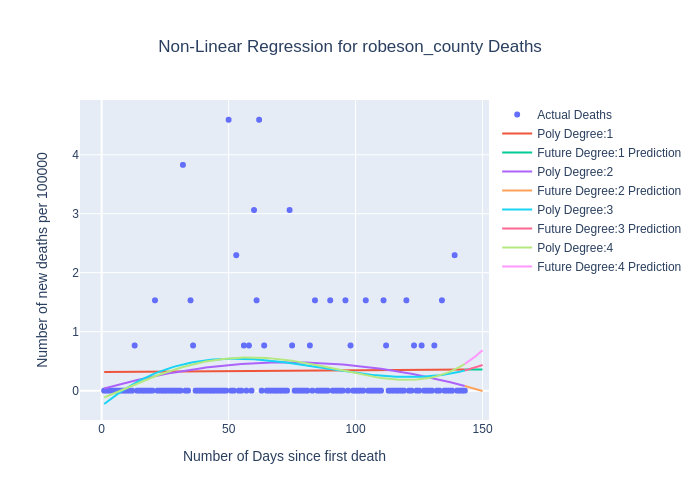

In [117]:
fig_deaths = deathsNonLinearModel(df_deaths,future_dates_deaths,"robeson_county")
Image(filename=fig_deaths)

### From the above plot we observe that non-linear model with degree 3 best fits the data 

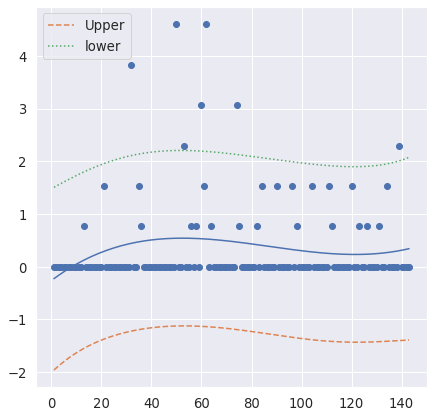

In [118]:
#Confidence Inteval
X = df_deaths["numOfDaysSinceFirstDeath"].values.reshape(-1,1)
y = df_deaths["Num_of_Deaths_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Stanly County Model

MAE for degree =  1 is  10.319060289141829
MSE for degree =  1 is  278.29075216520476
RMSE for degree =  1 is  16.68204879998871
R^2 for degree =  1 is  0.3251685190992488
-------------------------------------------------------
MAE for degree =  2 is  10.533037066568081
MSE for degree =  2 is  277.09196570246223
RMSE for degree =  2 is  16.646079589574907
R^2 for degree =  2 is  0.32807547463996367
-------------------------------------------------------
MAE for degree =  3 is  9.295698000784189
MSE for degree =  3 is  256.53307385697923
RMSE for degree =  3 is  16.01664989493681
R^2 for degree =  3 is  0.377929044411228
-------------------------------------------------------
MAE for degree =  4 is  9.192893806959185
MSE for degree =  4 is  256.1145036150699
RMSE for degree =  4 is  16.00357783794205
R^2 for degree =  4 is  0.37894404176205976
-------------------------------------------------------


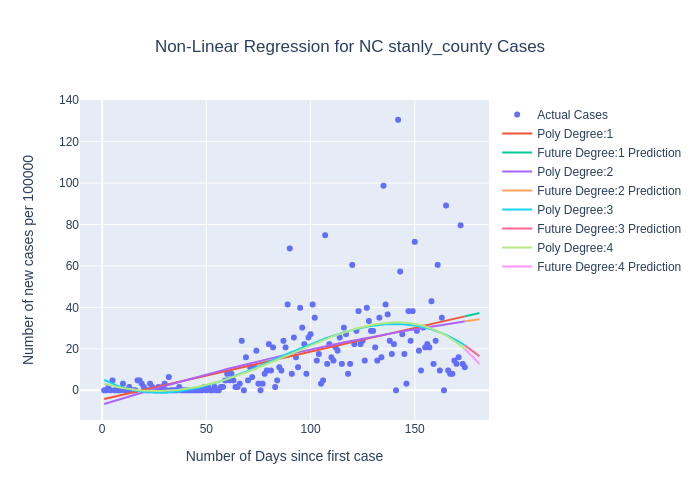

In [119]:
#Select the stanly county 
stanly_county_data = top5_county_data[top5_county_data['County Name']=='stanly county'].reset_index()

# Get the index of the row when the first case was detected 
stanly_county_data_first_case_index = stanly_county_data['Num_of_Cases_per_day_normalized'].ne(0).idxmax() 

# Get the index of the row when the first death was detected 
stanly_county_data_first_death_index= stanly_county_data['Num_of_Deaths_per_day_normalized'].ne(0).idxmax() 

# Assign number of days since the first case
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=stanly_county_data_first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1        
stanly_county_data.insert(1, "numOfDaysSinceFirstCase", numOfCasesSinceDay1)

# Assign number of days since the first death
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(NC_data_cleaned))):
    if i<=stanly_county_data_first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1        
stanly_county_data.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)

#Select the wo colums which are required
stanly_county_cases_brfore_drop = stanly_county_data[['numOfDaysSinceFirstCase','Num_of_Cases_per_day_normalized']]
#Drop all the rows before the first case
df_cases = stanly_county_cases_brfore_drop[stanly_county_cases_brfore_drop['numOfDaysSinceFirstCase']!=0]

stanly_county_deaths_before_drop = stanly_county_data[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day_normalized']]
df_deaths = stanly_county_deaths_before_drop[stanly_county_deaths_before_drop['numOfDaysSinceFirstDeath']!=0]
df_deaths

future_dates_cases = np.arange(174,182).reshape(-1,1)
future_dates_deaths = np.arange(157,165).reshape(-1,1)
fig_cases = casesNonLinearModel(df_cases,future_dates_cases,"stanly_county")
Image(filename=fig_cases)

### From the above plot we observe that non-linear model with degree 2 best fits the data 

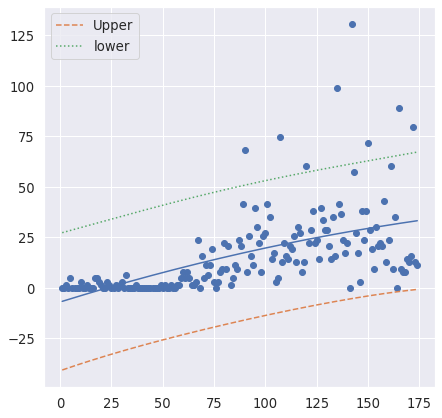

In [120]:
#Confidence Interval
X = df_cases["numOfDaysSinceFirstCase"].values.reshape(-1,1)
y = df_cases["Num_of_Cases_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

MAE for degree = 1 is  1.0013406272037697
MSE for degree = 1 is  10.062595413997022
RMSE for degree = 1 is  3.1721594244295197
R^2 for degree = 1 is  0.02389503012803973
-------------------------------------------------------
MAE for degree = 2 is  0.9377968503343377
MSE for degree = 2 is  9.992056115465036
RMSE for degree = 2 is  3.1610213721936518
R^2 for degree = 2 is  0.030737574922455102
-------------------------------------------------------
MAE for degree = 3 is  0.9642407278713918
MSE for degree = 3 is  9.980463495027497
RMSE for degree = 3 is  3.15918715732821
R^2 for degree = 3 is  0.031862097369932396
-------------------------------------------------------
MAE for degree = 4 is  0.9490574846261502
MSE for degree = 4 is  9.964111172987717
RMSE for degree = 4 is  3.156598037917992
R^2 for degree = 4 is  0.033448326583696786
-------------------------------------------------------


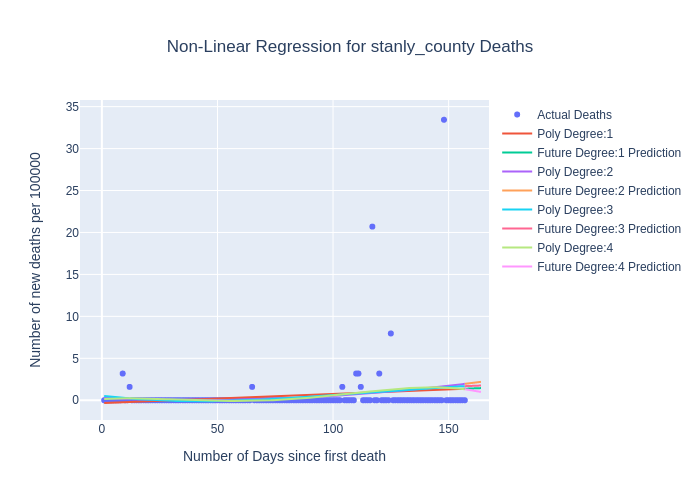

In [121]:
fig_deaths = deathsNonLinearModel(df_deaths,future_dates_deaths,"stanly_county")
Image(filename=fig_deaths)

### From the above plot we observe that non-linear model with degree 1 best fits the data 

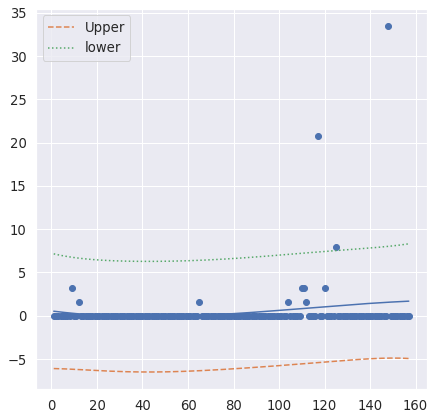

In [122]:
#Confidence Inteval
X = df_deaths["numOfDaysSinceFirstDeath"].values.reshape(-1,1)
y = df_deaths["Num_of_Deaths_per_day_normalized"].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

# print(np.sqrt(mean_squared_error(y,ypred)))
# model.summary()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Member task 2 Conclusion
- After analyzing the trend lines and prediction paths of above counties, we ca observe that the Montgomery county is at higher risk and the number of cases are predicted to increase at a higher rate when compared to other counties. 
- The second county which is at most risk is the Robeson County 

### Menber Task 3

In [33]:
hospital_data = pd.read_csv("../../data/COVID_HospitalBeds_merged_df.csv")
hospital_data

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_CITY,HQ_ZIP_CODE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
0,AL,1001,autauga county,2020-01-22,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
1,AL,1001,autauga county,2020-01-23,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
2,AL,1001,autauga county,2020-01-24,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
3,AL,1001,autauga county,2020-01-25,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
4,AL,1001,autauga county,2020-01-26,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551634,WY,56045,weston county,2020-09-10,21,0,6927,Weston County Health Services,Critical Access Hospital,Newcastle,82701,12,12,2,2,0,0.442694,0,0
1551635,WY,56045,weston county,2020-09-11,21,0,6927,Weston County Health Services,Critical Access Hospital,Newcastle,82701,12,12,2,2,0,0.442694,0,0
1551636,WY,56045,weston county,2020-09-12,23,0,6927,Weston County Health Services,Critical Access Hospital,Newcastle,82701,12,12,2,2,0,0.442694,0,0
1551637,WY,56045,weston county,2020-09-13,23,0,6927,Weston County Health Services,Critical Access Hospital,Newcastle,82701,12,12,2,2,0,0.442694,0,0


In [34]:
def nonLinearModelStateDeaths(state,num_degree,prediction):
    state_hospital_data= hospital_data[hospital_data['State']==state]

    #Calculate new cases and deaths for each day
    state_hospital_data['Num_of_Cases_per_day'] = state_hospital_data['Num of Cases'].diff()
    state_hospital_data['Num_of_Deaths_per_day'] = state_hospital_data['Num of Deaths'].diff()
    
    
    #Drop the first date as we we are using .diff, we will get the first value as NAN 
    state_hospital_data = state_hospital_data[state_hospital_data['Date'] != '2020-01-22']

    # Get the total number of cases and deaths for edf_Mexico_cases_newach day 
    state_hospital_data_groupedBydate = state_hospital_data.groupby("Date").sum().reset_index()
    
    # Get the index of the row when the first death was detected 
    state_first_death_index= state_hospital_data_groupedBydate['Num_of_Deaths_per_day'].ne(0).idxmax() 

    # Assign number of days since the first death
    numOfDeathsSinceDay1=[]
    counter=1
    for i,index in enumerate(range(len(NC_data_cleaned))):
        if i<=state_first_death_index:
            numOfDeathsSinceDay1.insert(index, 0) 
        else:
            numOfDeathsSinceDay1.insert(index, counter) 
            counter = counter+1        
    state_hospital_data_groupedBydate.insert(3, "numOfDaysSinceFirstDeath", numOfDeathsSinceDay1)
    
    max_num_icu_beds = state_hospital_data_groupedBydate.iloc[0]['NUM_ICU_BEDS']
    state_no_return_df=state_hospital_data_groupedBydate[['numOfDaysSinceFirstDeath','Num_of_Deaths_per_day','NUM_ICU_BEDS']]
    df_deaths = state_no_return_df[state_no_return_df['numOfDaysSinceFirstDeath']!=0]


    #Define the independent and dependent variable
    X = df_deaths.numOfDaysSinceFirstDeath.values.reshape(-1, 1)
    y_d = df_deaths.Num_of_Deaths_per_day.values.reshape(-1, 1)
    x_range = np.linspace(X.min(), X.max(), y_d.shape[0]).reshape(-1, 1)
    last_date = len(df_deaths)-1
    if prediction == True :
        predictioDays=400
    else:
        predictioDays=last_date+7
    future_dates = np.arange(last_date,predictioDays).reshape(-1,1)

    fig = go.Figure()
    fig.add_traces(go.Scatter(x=df_deaths['numOfDaysSinceFirstDeath'], y=df_deaths['Num_of_Deaths_per_day']
                              , name= "Actual Deaths", mode="markers"))
    for degree in num_degree:

        #Define and fit the LinearRegression model
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)
        future_dates_poly = poly.transform(future_dates)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, df_deaths.Num_of_Deaths_per_day)

        #predict the number of new deaths per day since the fist deaths
        y_poly = model.predict(x_range_poly)

        # Predict the number of new deaths for the next 1 week's of data
        future_cases = model.predict(future_dates_poly)

        #Caluculate the metrics and print
        print("MAE for degree =",degree,"is ",metrics.mean_absolute_error(y_d,y_poly))
        print("MSE for degree =",degree,"is ",metrics.mean_squared_error(y_d,y_poly))
        print("RMSE for degree =",degree,"is ",np.sqrt(metrics.mean_squared_error(y_d,y_poly)))
        print("R^2 for degree =",degree,"is ",r2_score(y_d,y_poly))
        print("-------------------------------------------------------")
        
        #Plot the trend line and prediction path
        fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name="Poly Degree:{}".format(degree)))
        fig.add_traces(go.Scatter(x=future_dates.squeeze(),y=future_cases.squeeze(),name='Deg:{} Prediction'.format(degree),mode='lines')),
        fig.update_layout(
        title={'text':"Non-Linear Regression for {} Deaths".format(state),
               'y':0.92,'x':0.5,
               'xanchor':'center', 
               'yanchor':'top'},
        xaxis_title="Number of Days since first death",
        yaxis_title="Number of new deaths ",
    )
    print("Maximum number of ICU beds in {}".format(state)," is ",max_num_icu_beds)
    fig_name = "../../images/{}_nlrHospitalDeaths.png".format(state)
    fig.write_image(fig_name)
    #fig.show()
    return fig_name

MAE for degree = 1 is  10.016441209713562
MSE for degree = 1 is  182.56745331767942
RMSE for degree = 1 is  13.511752414756549
R^2 for degree = 1 is  0.13012489662471427
-------------------------------------------------------
MAE for degree = 2 is  9.98097888723198
MSE for degree = 2 is  182.23785833748946
RMSE for degree = 2 is  13.499550301305947
R^2 for degree = 2 is  0.1316953105306684
-------------------------------------------------------
MAE for degree = 3 is  9.89590731654668
MSE for degree = 3 is  181.66145111036204
RMSE for degree = 3 is  13.478184266078351
R^2 for degree = 3 is  0.1344417052859881
-------------------------------------------------------
MAE for degree = 4 is  9.49682891672864
MSE for degree = 4 is  172.58898159719814
RMSE for degree = 4 is  13.137312571344191
R^2 for degree = 4 is  0.17766909994050029
-------------------------------------------------------
Maximum number of ICU beds in NC  is  2648


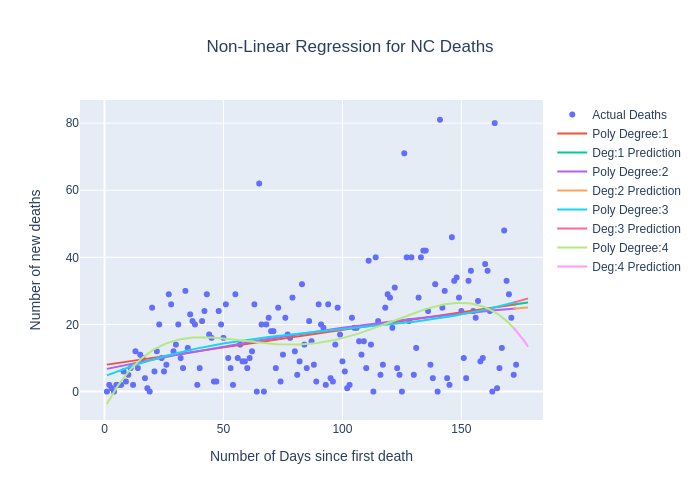

In [35]:
#NC Modeling
fig_name = nonLinearModelStateDeaths("NC",[1,2,3,4],False)
Image(filename=fig_name)

#### From the above plot and the model metics we observe that non-linear model with degree 3 best fits the data so we will use degre 3 for prediction

MAE for degree = 3 is  9.89590731654668
MSE for degree = 3 is  181.66145111036204
RMSE for degree = 3 is  13.478184266078351
R^2 for degree = 3 is  0.1344417052859881
-------------------------------------------------------
Maximum number of ICU beds in NC  is  2648


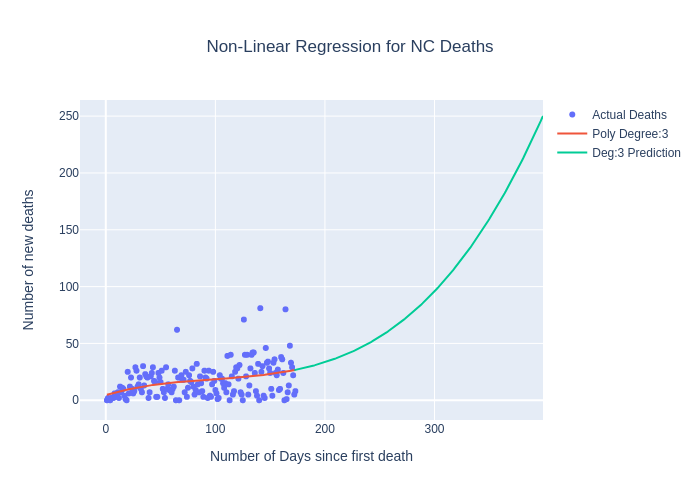

In [36]:
#NC Prediction
state="NC"
fig_name = nonLinearModelStateDeaths("NC",[3],True)

Image(filename=fig_name)

MAE for degree = 1 is  30.44686367592943
MSE for degree = 1 is  1679.6492720474353
RMSE for degree = 1 is  40.98352439758488
R^2 for degree = 1 is  0.4708271647849669
-------------------------------------------------------
MAE for degree = 2 is  29.904955893120576
MSE for degree = 2 is  1639.9821514182895
RMSE for degree = 2 is  40.496693092378415
R^2 for degree = 2 is  0.48332427536481704
-------------------------------------------------------
MAE for degree = 3 is  29.760744671416372
MSE for degree = 3 is  1638.4273836259965
RMSE for degree = 3 is  40.47749230901041
R^2 for degree = 3 is  0.4838141043394969
-------------------------------------------------------
MAE for degree = 4 is  30.2992486010857
MSE for degree = 4 is  1623.338600482323
RMSE for degree = 4 is  40.2906763467967
R^2 for degree = 4 is  0.4885678194685783
-------------------------------------------------------
Maximum number of ICU beds in CA  is  8652


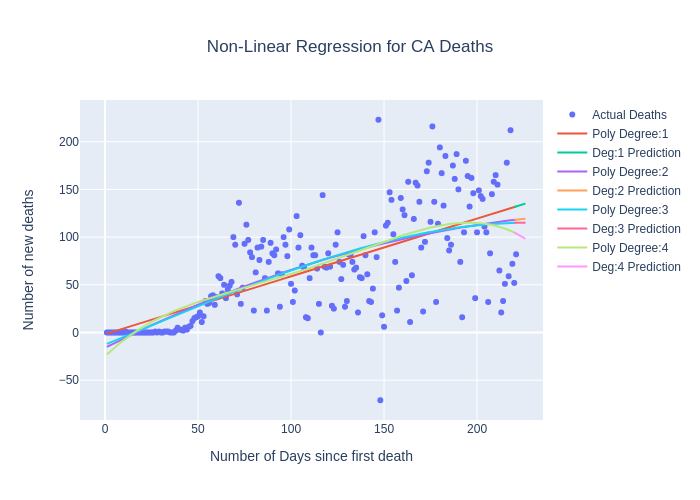

In [37]:
#CA Modeling
fig_name = nonLinearModelStateDeaths("CA",[1,2,3,4],False)
Image(filename=fig_name)

MAE for degree = 4 is  30.2992486010857
MSE for degree = 4 is  1623.338600482323
RMSE for degree = 4 is  40.2906763467967
R^2 for degree = 4 is  0.4885678194685783
-------------------------------------------------------
Maximum number of ICU beds in CA  is  8652


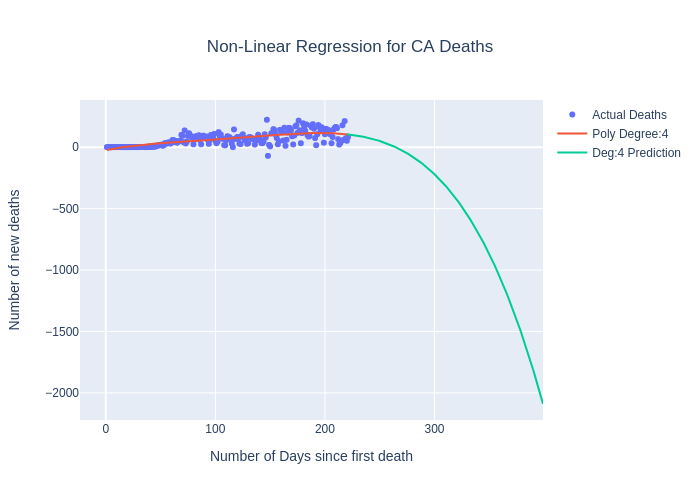

In [38]:
#NC Prediction
fig_name = nonLinearModelStateDeaths("CA",[4],True)
Image(filename=fig_name)

MAE for degree = 1 is  34.075492690347254
MSE for degree = 1 is  2557.4180715641783
RMSE for degree = 1 is  50.57092120541387
R^2 for degree = 1 is  0.40084818834971536
-------------------------------------------------------
MAE for degree = 2 is  33.780159606887416
MSE for degree = 2 is  2546.37164921648
RMSE for degree = 2 is  50.461585876946835
R^2 for degree = 2 is  0.40343614377064096
-------------------------------------------------------
MAE for degree = 3 is  35.566900387881894
MSE for degree = 3 is  2460.299876788789
RMSE for degree = 3 is  49.601410028231946
R^2 for degree = 3 is  0.42360103544611927
-------------------------------------------------------
MAE for degree = 4 is  31.270717213920978
MSE for degree = 4 is  1979.49385877879
RMSE for degree = 4 is  44.491503220039554
R^2 for degree = 4 is  0.5362442516437964
-------------------------------------------------------
Maximum number of ICU beds in FL  is  6231


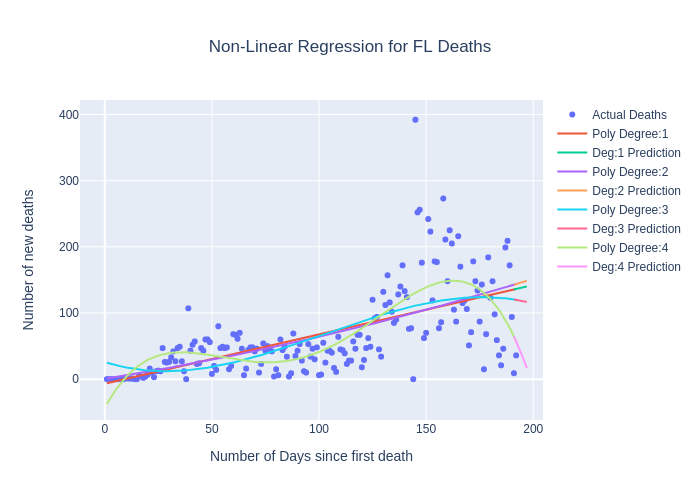

In [39]:
#FL Modeling
fig_name = nonLinearModelStateDeaths("FL",[1,2,3,4],False)
Image(filename=fig_name)

MAE for degree = 3 is  35.566900387881894
MSE for degree = 3 is  2460.299876788789
RMSE for degree = 3 is  49.601410028231946
R^2 for degree = 3 is  0.42360103544611927
-------------------------------------------------------
Maximum number of ICU beds in FL  is  6231


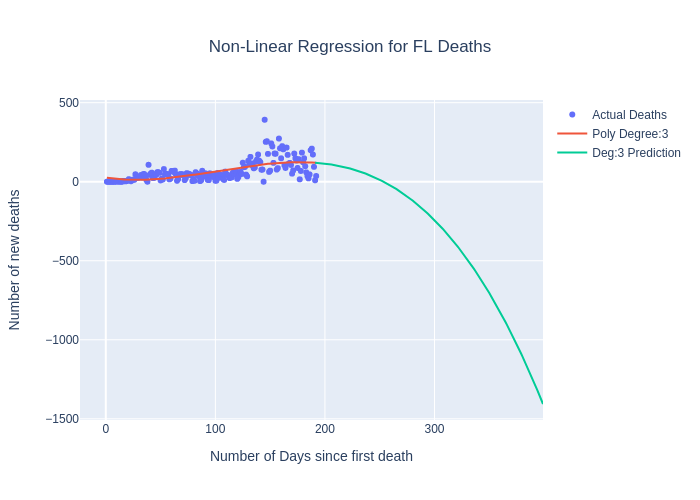

In [40]:
#FL Prediction
fig_name = nonLinearModelStateDeaths("FL",[3],True)
Image(filename=fig_name)

MAE for degree = 1 is  147.48992793267408
MSE for degree = 1 is  64601.31411406061
RMSE for degree = 1 is  254.1678856859391
R^2 for degree = 1 is  0.2795901308178026
-------------------------------------------------------
MAE for degree = 2 is  143.21138861440824
MSE for degree = 2 is  64516.20808394924
RMSE for degree = 2 is  254.00040961374302
R^2 for degree = 2 is  0.28053920166659196
-------------------------------------------------------
MAE for degree = 3 is  141.5487933529721
MSE for degree = 3 is  53421.75585879898
RMSE for degree = 3 is  231.1314687765363
R^2 for degree = 3 is  0.40426041362300713
-------------------------------------------------------
MAE for degree = 4 is  108.52975942718547
MSE for degree = 4 is  38489.557841396534
RMSE for degree = 4 is  196.18755781495557
R^2 for degree = 4 is  0.5707787417382275
-------------------------------------------------------
Maximum number of ICU beds in NY  is  4230


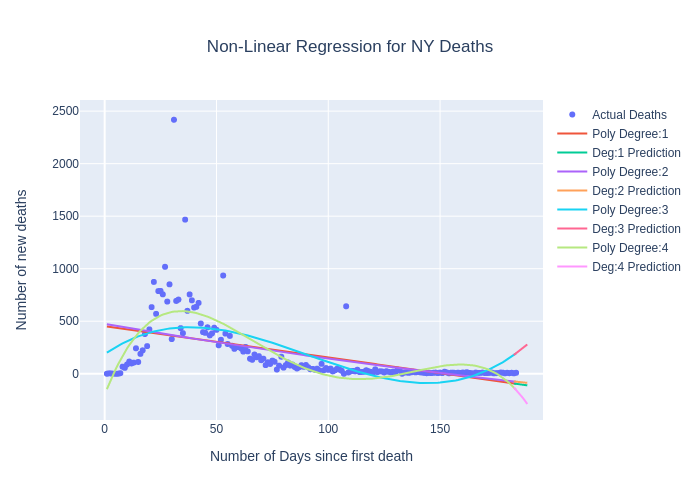

In [41]:
#NY Modeling
fig_name = nonLinearModelStateDeaths("NY",[1,2,3,4],False)
Image(filename=fig_name)

MAE for degree = 3 is  35.566900387881894
MSE for degree = 3 is  2460.299876788789
RMSE for degree = 3 is  49.601410028231946
R^2 for degree = 3 is  0.42360103544611927
-------------------------------------------------------
Maximum number of ICU beds in FL  is  6231


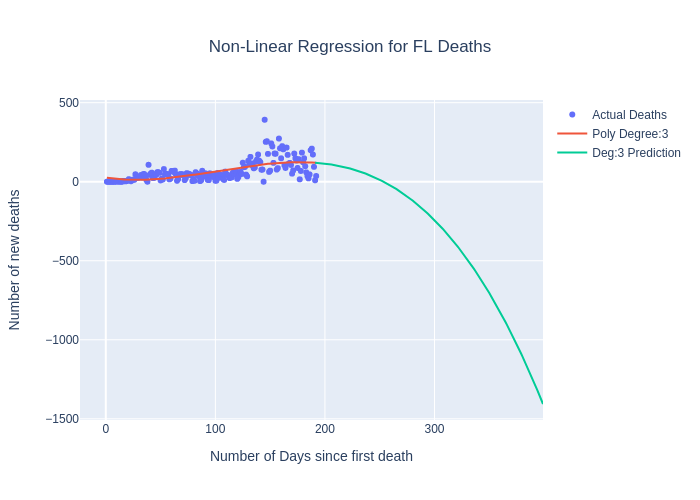

In [42]:
#NY Prediction
fig_name = nonLinearModelStateDeaths("FL",[3],True)
Image(filename=fig_name)

MAE for degree = 1 is  49.89729564157247
MSE for degree = 1 is  9417.734480950841
RMSE for degree = 1 is  97.04501265366933
R^2 for degree = 1 is  0.26126294335886247
-------------------------------------------------------
MAE for degree = 2 is  46.17628142894756
MSE for degree = 2 is  9340.50059308143
RMSE for degree = 2 is  96.64626528263484
R^2 for degree = 2 is  0.267321251236729
-------------------------------------------------------
MAE for degree = 3 is  49.99139486160554
MSE for degree = 3 is  8801.43933687982
RMSE for degree = 3 is  93.81598657414321
R^2 for degree = 3 is  0.3096057864995502
-------------------------------------------------------
MAE for degree = 4 is  38.509779053608696
MSE for degree = 4 is  7687.019610251996
RMSE for degree = 4 is  87.67565004179893
R^2 for degree = 4 is  0.39702204891139303
-------------------------------------------------------
Maximum number of ICU beds in TX  is  8719


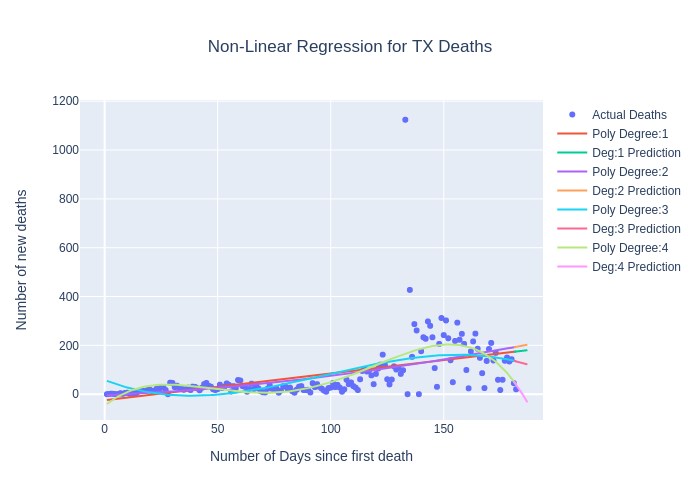

In [43]:
#TX Modeling
fig_name = nonLinearModelStateDeaths("TX",[1,2,3,4],False)
Image(filename=fig_name)

MAE for degree = 3 is  49.99139486160554
MSE for degree = 3 is  8801.43933687982
RMSE for degree = 3 is  93.81598657414321
R^2 for degree = 3 is  0.3096057864995502
-------------------------------------------------------
Maximum number of ICU beds in TX  is  8719


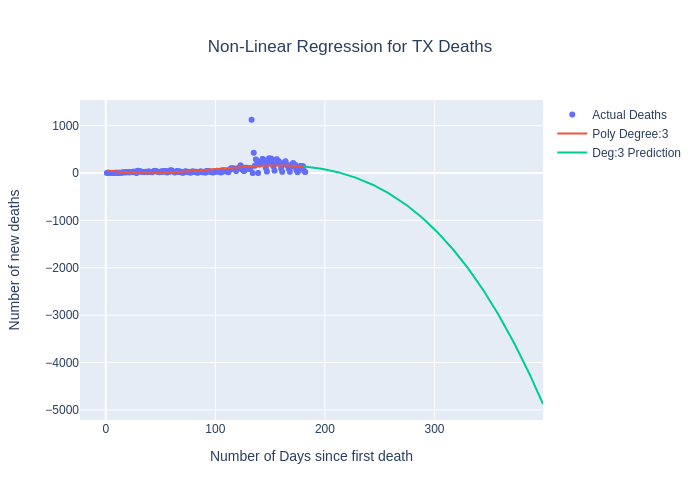

In [44]:
#TX Prediction
fig_name = nonLinearModelStateDeaths("TX",[3],True)
Image(filename=fig_name)

MAE for degree = 1 is  14.128074369007727
MSE for degree = 1 is  469.50373181194817
RMSE for degree = 1 is  21.66803479349127
R^2 for degree = 1 is  0.11623191499357521
-------------------------------------------------------
MAE for degree = 2 is  14.517576534124325
MSE for degree = 2 is  405.8982556300398
RMSE for degree = 2 is  20.146916777264945
R^2 for degree = 2 is  0.23595937629461106
-------------------------------------------------------
MAE for degree = 3 is  10.60363532377017
MSE for degree = 3 is  285.33145564813907
RMSE for degree = 3 is  16.891757032592526
R^2 for degree = 3 is  0.46290771070749936
-------------------------------------------------------
MAE for degree = 4 is  9.605184887043691
MSE for degree = 4 is  273.96833972341227
RMSE for degree = 4 is  16.551988995991156
R^2 for degree = 4 is  0.48429701716039053
-------------------------------------------------------
Maximum number of ICU beds in MD  is  1311


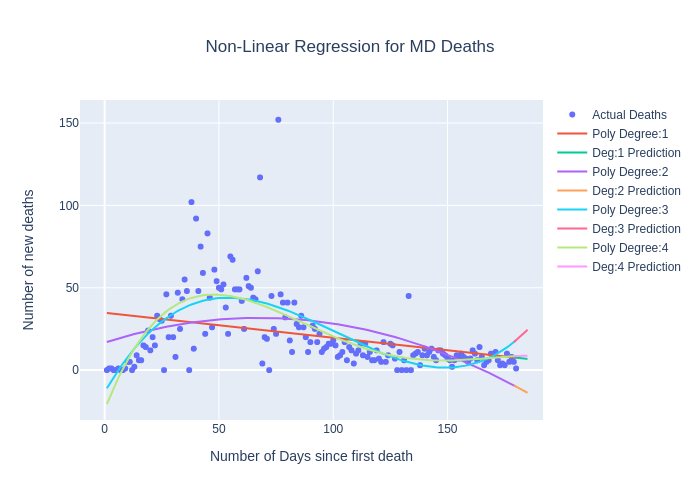

In [45]:
#MD Modeling
fig_name = nonLinearModelStateDeaths("MD",[1,2,3,4],False)
Image(filename=fig_name)

MAE for degree = 3 is  10.60363532377017
MSE for degree = 3 is  285.33145564813907
RMSE for degree = 3 is  16.891757032592526
R^2 for degree = 3 is  0.46290771070749936
-------------------------------------------------------
Maximum number of ICU beds in MD  is  1311


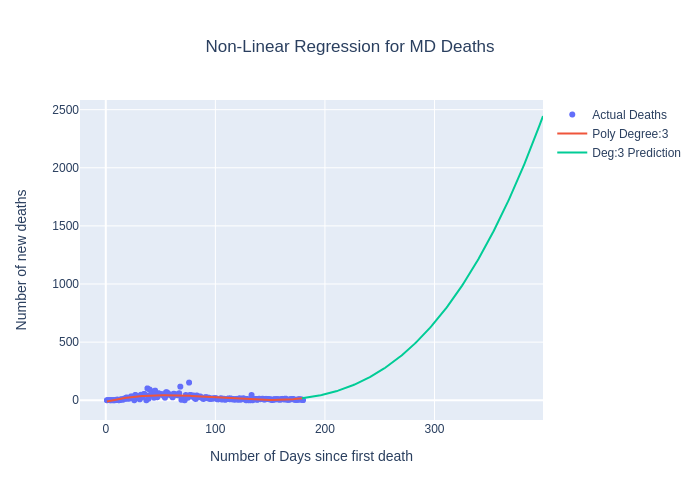

In [46]:
#MD Prediction
fig_name = nonLinearModelStateDeaths("MD",[3],True)
Image(filename=fig_name)

### Member task 3 conclusion
- when we use non-linear model with degree 3 for modeling the deaths in NC, we observe from the prediction of the number of deaths is increasing slowly, it will take 792 days from the day, the first case was detected the number of deaths are crossing 2648 which is the number of ICU beds in the state of NC. Thus after 792 days NC will go into point of no return.
- when we use non-linear model with degree 3 for modeling the deaths in md, we observe from the prediction of the number of deaths is increasing rapidly, it will take 346 days from the day, the first case was detected the number of deaths are crossing 1311 which is the number of ICU beds in the state of NC. Thus after 346 days MD will go into point of no return.
- All the other states have a decrese in the predected number of deaths.
- Thus MD might reach the point of no return faster when compared to other states

###  Member task 4

### Decision tree classifier

In [47]:
NC_data_cleaned

,Date,numOfDaysSinceFirstCase,Num_of_Cases_per_day,numOfDaysSinceFirstDeath,Num_of_Deaths_per_day
0,2020-01-23,0,0.0,0,0.0
1,2020-01-24,0,0.0,0,0.0
2,2020-01-25,0,0.0,0,0.0
3,2020-01-26,0,0.0,0,0.0
4,2020-01-27,0,0.0,0,0.0
...,...,...,...,...,...
231,2020-09-10,191,1225.0,169,33.0
232,2020-09-11,192,1532.0,170,33.0
233,2020-09-12,193,1453.0,171,24.0
234,2020-09-13,194,1193.0,172,5.0


In [48]:
# Read the Data 
df_cases_brfore_drop = NC_data_cleaned[['numOfDaysSinceFirstCase','Num_of_Cases_per_day']]

#Drop all the rows which has zero in the numOfDaysSinceFirstCase column
df_cases = df_cases_brfore_drop.iloc[40:].reset_index()
df_cases

,index,numOfDaysSinceFirstCase,Num_of_Cases_per_day
0,40,0,1.0
1,41,1,0.0
2,42,2,0.0
3,43,3,1.0
4,44,4,0.0
...,...,...,...
191,231,191,1225.0
192,232,192,1532.0
193,233,193,1453.0
194,234,194,1193.0


In [49]:
X = df_cases['numOfDaysSinceFirstCase'][0:182].values.reshape(-1, 1) 
print(X.shape)
y = df_cases['Num_of_Cases_per_day'][7:189].values.reshape(-1, 1) 
print(y.shape)

(182, 1)
(182, 1)


In [50]:
#Define the independent and dependent variable
#X-variable is the previous weeks data, Y-variable is current week data.

X_train = df_cases['numOfDaysSinceFirstCase'][0:182].values.reshape(-1, 1) 
X_test = df_cases['numOfDaysSinceFirstCase'][182:189].values.reshape(-1, 1)
Y_train = df_cases['Num_of_Cases_per_day'][7:189].values.reshape(-1, 1)
Y_test = df_cases['Num_of_Cases_per_day'][189:].values.reshape(-1, 1) 
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20,random_state=0)

In [51]:
print("X_train.shape ",X_train.shape)
print("Y_train.shape ",Y_train.shape)
print("X_test.shape ",X_test.shape)
print("Y_test.shape ",Y_test.shape)

X_train.shape  (182, 1)
Y_train.shape  (182, 1)
X_test.shape  (7, 1)
Y_test.shape  (7, 1)


In [52]:
#Define the decision tree classifier
clf = DecisionTreeClassifier()
#Fit the data with the decision tree classifier
clf = clf.fit(X_train,Y_train)
# plot_tree(clf, filled=True)
# plt.show()

In [53]:
#Predict the values and calculate the RMSE
y_pred =clf.predict(X_test) 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error for Decision Tree Classifier:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 275.57142857142856
Mean Squared Error: 96225.85714285714
Root Mean Squared Error for Decision Tree Classifier: 310.20292897207975


### Random Forest

In [54]:
regr = RandomForestRegressor(random_state=1, verbose = 1)
regr.fit(X_train,Y_train)
y_pred = regr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error for Random Forest Regressor:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 255.97
Mean Squared Error: 83494.14124285713
Root Mean Squared Error for Random Forest Regressor: 288.9535278255954


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### ARIMA Model 

In [55]:
df_cases = NC_data_cleaned[['Date','Num_of_Cases_per_day']]
df_cases['Date']= pd.to_datetime(df_cases['Date'])
df_cases.set_index('Date',inplace=True)


(7, 1)

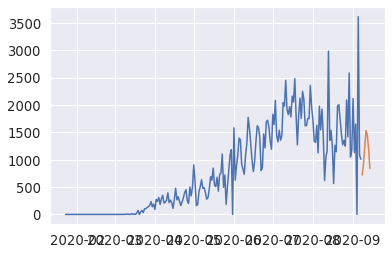

In [60]:
train = df_cases[:229]
test = df_cases[229:]
plt.plot(train)
plt.plot(test)
test.shape
#df_cases.shape

In [61]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3387.464, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3314.651, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3332.936, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3252.145, Time=1.62 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3246.684, Time=4.86 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3248.648, Time=10.64 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=15.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3241.004, Time=6.69 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=3241.478, Time=12.14 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.52 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=23.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=32

In [62]:
print(arima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  229
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1584.953
Date:                              Sun, 15 Nov 2020   AIC                           3181.906
Time:                                      22:39:48   BIC                           3202.157
Sample:                                           0   HQIC                          3190.087
                                              - 229                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9904      0.039    -25.616      0.000      -1.066      -0.915
ma.L2          0.15

In [63]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7),index=test.index)
prediction.columns = ['predicted_cases']
prediction

,predicted_cases
Date,
2020-09-08,1700.710435
2020-09-09,1695.067820
2020-09-10,1937.138693
2020-09-11,1781.902737
2020-09-12,1664.239194
2020-09-13,1554.269692
2020-09-14,1428.018091


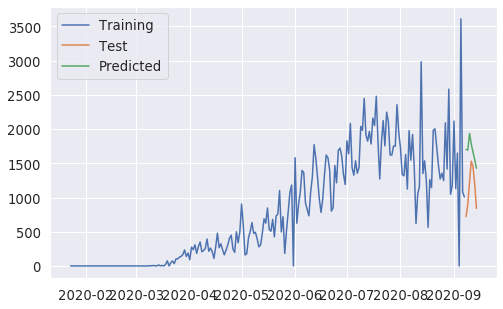

In [64]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

In [65]:
print("RMSE for Arima model is ",np.sqrt(metrics.mean_squared_error(test['Num_of_Cases_per_day'], prediction['predicted_cases'])))

RMSE for Arima model is  618.3532151897653


### Member Task 4 Conclusion 
- Among the above 3 models , Random Forest has less RMSE value and better fits the number of cases data

### Task 1 Member Task 5 

In [66]:
merged_data = pd.read_csv("../../data/mergedeDemographicEnrichmentData.csv")
merged_data

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,TotalMales,TotalFemales,sexRatioM/100F,...,age75to84,age85over,medianAge,65overMale,65overFemale,whitePopulation,blackPopulation,AmericanIndian&AlaskanNative,AsianPopulation,NativeHawiianOtherPacificPopulation
0,AL,1003,baldwin county,2020-01-22,0,0,223234,109192,114042,95.7,...,14425,4345,43.0,21573,26115,190912,18338,2428,2160,0
1,AL,1003,baldwin county,2020-01-23,0,0,223234,109192,114042,95.7,...,14425,4345,43.0,21573,26115,190912,18338,2428,2160,0
2,AL,1003,baldwin county,2020-01-24,0,0,223234,109192,114042,95.7,...,14425,4345,43.0,21573,26115,190912,18338,2428,2160,0
3,AL,1003,baldwin county,2020-01-25,0,0,223234,109192,114042,95.7,...,14425,4345,43.0,21573,26115,190912,18338,2428,2160,0
4,AL,1003,baldwin county,2020-01-26,0,0,223234,109192,114042,95.7,...,14425,4345,43.0,21573,26115,190912,18338,2428,2160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196468,WY,56025,natrona county,2020-09-10,335,2,79858,40278,39580,101.8,...,3910,1214,38.7,5765,6908,74769,1024,840,787,0
196469,WY,56025,natrona county,2020-09-11,347,2,79858,40278,39580,101.8,...,3910,1214,38.7,5765,6908,74769,1024,840,787,0
196470,WY,56025,natrona county,2020-09-12,356,2,79858,40278,39580,101.8,...,3910,1214,38.7,5765,6908,74769,1024,840,787,0
196471,WY,56025,natrona county,2020-09-13,368,2,79858,40278,39580,101.8,...,3910,1214,38.7,5765,6908,74769,1024,840,787,0


In [67]:
#Select last date as it has the total number of cases and deaths
mergedEnrichmentData_lastDate = merged_data[merged_data['Date']=='2020-09-14']
mergedEnrichmentData_lastDate = mergedEnrichmentData_lastDate.replace({'whitePopulation' : { 'N' : 0},
                   'blackPopulation' : { 'N' : 0},
                   'AmericanIndian&AlaskanNative':{'N':0},
                    'AsianPopulation':{'N':0},
                    'NativeHawiianOtherPacificPopulation':{'N':0},})
for column in ['whitePopulation','blackPopulation','AmericanIndian&AlaskanNative','AsianPopulation','NativeHawiianOtherPacificPopulation']:
    mergedEnrichmentData_lastDate[column] = pd.to_numeric(mergedEnrichmentData_lastDate[column])
df_enrich_cases = mergedEnrichmentData_lastDate.drop(['State','countyFIPS','County Name','Date','population','Num of Deaths'],axis=1)
df_enrich_deaths = mergedEnrichmentData_lastDate.drop(['State','countyFIPS','County Name','population','Date','Num of Cases'],axis=1) 

#### Decision tree

In [68]:
def decisionTree(X,y): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20,random_state=0)
    #Define the decision tree classifier
    clf = DecisionTreeClassifier(random_state=1)
    #Fit the data with the decision tree classifier
    clf = clf.fit(X_train,Y_train)
    #Predict the values and calculate the RMSE
    y_pred =clf.predict(X_test) 
    
    # get importance
    importance = clf.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    print('Root Mean Squared Error for Decision Tree Classifier:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

#### Random forest

In [69]:
def randomForest(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20,random_state=0)
    regr = RandomForestRegressor(n_estimators=1000, random_state=1)
    regr.fit(X_train,Y_train)
    y_pred = regr.predict(X_test)
    # get importance
    importance = regr.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    print('Root Mean Squared Error for Random Forest Regressor:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
    print("---------------------------------------------------------------------------------------------------------")

### Predict spread rate based on Enrichment data  

Feature: 0, Score: 0.15484
Feature: 1, Score: 0.15130
Feature: 2, Score: 0.15208
Feature: 3, Score: 0.12720
Feature: 4, Score: 0.12902
Feature: 5, Score: 0.14781
Feature: 6, Score: 0.13775


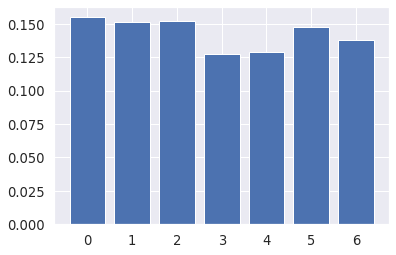

Root Mean Squared Error for Decision Tree Classifier: 14992.504442481628
Feature: 0, Score: 0.09406
Feature: 1, Score: 0.20765
Feature: 2, Score: 0.40282
Feature: 3, Score: 0.10117
Feature: 4, Score: 0.03095
Feature: 5, Score: 0.13578
Feature: 6, Score: 0.02757


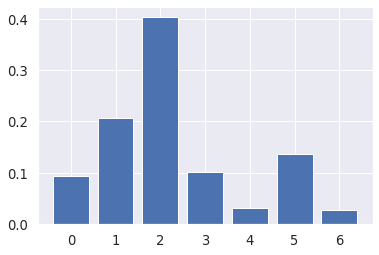

Root Mean Squared Error for Random Forest Regressor: 12979.40691052977
---------------------------------------------------------------------------------------------------------


In [70]:
#For cases 
# Features selected are 
# ['sexRatioM/100F','age<5','ageFrom45to54','age75to84','whitePopulation','blackPopulation']
df_encrich_cases_selected = df_enrich_cases[['TotalMales','TotalFemales','age<5','ageFrom45to54','age75to84','whitePopulation','blackPopulation']]
decisionTree(df_encrich_cases_selected,df_enrich_cases['Num of Cases'])
randomForest(df_encrich_cases_selected,df_enrich_cases['Num of Cases'])

### Conclusion on Relative importance of variables with respect to cases
The Chosen variables are :
- 0: 'TotalMales'
- 1: 'TotalFemales'
- 2: 'age<5'
- 3:'ageFrom45to54'
- 4: 'age75to84'
- 5: 'whitePopulation'
- 6: 'blackPopulation'

We observe by the RMSE value of Decision tree and Random Foreset that Random Forest model better fits the new cases data.
From the above random forest plot we observe that 
- 'TotalFemales' has more feature importance than 'TotalMales'. it means that, more number of females are  affected by covid-19 than males
- Among all the age groups, the age group that has more importance is age<5 which means that kids with the age<5 are more affected by Covid-19
- 'whitePopulation' ha more feature importance score when compared to 'blackPopulation' . This means that white population is more affected by covid-19 than black

Feature: 0, Score: 0.13426
Feature: 1, Score: 0.11794
Feature: 2, Score: 0.13749
Feature: 3, Score: 0.15251
Feature: 4, Score: 0.15848
Feature: 5, Score: 0.14386
Feature: 6, Score: 0.15545


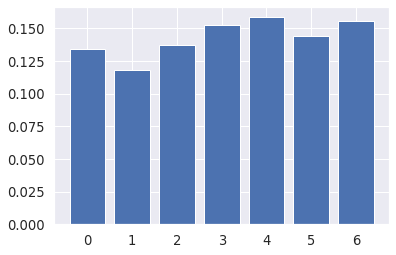

Root Mean Squared Error for Decision Tree Classifier: 447.8124002114418
Feature: 0, Score: 0.05295
Feature: 1, Score: 0.13106
Feature: 2, Score: 0.07126
Feature: 3, Score: 0.15977
Feature: 4, Score: 0.19630
Feature: 5, Score: 0.09504
Feature: 6, Score: 0.29362


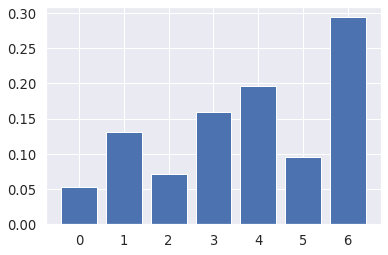

Root Mean Squared Error for Random Forest Regressor: 391.14589483899425
---------------------------------------------------------------------------------------------------------


In [71]:
#For deaths 
# Features selected are 
# ['TotalMales','TotalFemales','age<5','ageFrom45to54','age75to84','whitePopulation','blackPopulation']
df_encrich_cases_selected = df_enrich_cases[['TotalMales','TotalFemales','age<5','ageFrom45to54','age75to84','whitePopulation','blackPopulation']]
decisionTree(df_encrich_cases_selected,df_enrich_deaths['Num of Deaths'])
randomForest(df_encrich_cases_selected,df_enrich_deaths['Num of Deaths'])

### Conclusion on relative importance of variables  with respect to deaths
 The Chosen variables are :
- 0: 'TotalMales'
- 1: 'TotalFemales'
- 2: 'age<5'
- 3:'ageFrom45to54'
- 4: 'age75to84'
- 5: 'whitePopulation'
- 6: 'blackPopulation'

We observe by the RMSE value of Decision tree and Random Forest that Random Forest model better fits the new deaths data.
From The above random forest plot we observe that the 
From the above random forest plot we observe that 
- 'TotalFemales' has more feature importance than 'TotalMales'. This means that death rate in females is more than male population
- Among all the age groups, the age group that has more importance is 'age75to84'which means that death rate in  old people with the age>75 are more.
- 'blackPopulation' has more feature importance score when compared to 'whitePopulation'  . This means that black population has more death rate than white population.
